# 安裝/載入模組

In [ ]:
!pip install numpy pandas scikit-learn keras yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2023-12-25 20:06:38--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.0.78, 2607:f8b0:4025:810::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t86emjljvt7he1qv5f4o42v6dfu47ojn/1703534775000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=1ca75b21-b7e7-41c4-bc1d-664e60690dd9 [following]
--2023-12-25 20:06:41--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/t86emjljvt7he1qv5f4o42v6dfu47ojn/1703534775000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=1ca75b21-b7e7-41c4-bc1d-664e60690dd9
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to doc-0k-9o-docs.google

# 資料準備Class

In [ ]:
class Prepare_Data:
  def __init__(self, company:list =['聯電','2303.TW'], start_t='2022-01-01', end_t='2022-12-31') -> None:
    self.c_name = company[0]
    self.c_symbol = company[1]
    self.start_t = start_t
    self.end_t = end_t
    self.stock_price = yf.download(self.c_symbol, start='2013-01-01', end='2023-01-01')
    self.technical_data = self.__get_technical_indicators()[self.start_t:self.end_t]
    self.is_rising = self.technical_data['rising_rate'].apply(lambda x: 1 if x > 0 else 0).rename('is_rising')
    self.adj_close = self.stock_price[self.start_t:self.end_t]['Adj Close']
    self.target_field = pd.concat([self.adj_close,  self.is_rising], axis=1)
    # self.fundamental_source = pd.read_excel(r'//content/drive/MyDrive/專題資料/fundamental.xlsx', sheet_name=self.c_name,index_col=0)
    self.fundamental_source = pd.read_excel(r'fin_report/fundamental.xlsx', sheet_name=self.c_name,index_col=0)
    self.fundamental_data = self.__get_fundamental_data()[self.start_t:self.end_t]
    # self.sentimental_data = pd.read_excel(r'//content/drive/MyDrive/專題資料/sentimental_score.xlsx', sheet_name=self.c_name,index_col=0)
    self.sentimental_data = pd.read_excel(r'sent_score/sentimental_score.xlsx', sheet_name=self.c_name,index_col=0)
    self.data = pd.concat([self.technical_data, self.fundamental_data, self.sentimental_data, self.target_field], axis=1)[self.start_t:self.end_t].dropna()

  def get_data(self, type=0):
    d = {
      1:self.technical_data,
      2:self.fundamental_data,
      3:self.sentimental_data
    }

    if type==0:
      return self.data

    if isinstance(type, int):
      dataset = [d[type]]
    elif isinstance(type, list):
      dataset = [d[x] for x in type]

    dataset.append(self.target_field)
    return pd.concat(dataset, axis=1)[self.start_t:self.end_t].dropna()

  def plot_adj_price(self):
    """
    繪出調整後收盤價圖
    """
    plt.figure(figsize=(16, 8), dpi=200)
    plt.plot(self.stock_price[self.start_t:self.end_t].index, self.stock_price[self.start_t:self.end_t]['Adj Close'], label=self.c_symbol)
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.title(f'{self.c_symbol} Adj Close')
    plt.legend()
    plt.show()

  def __get_technical_indicators(self):
    dataset = self.stock_price.copy()
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()

    dataset['26ema'] = dataset['Adj Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    dataset['20sd'] = dataset['Adj Close'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    dataset['ema'] = dataset['Adj Close'].ewm(com=0.5).mean()

    dataset['momentum'] = dataset['Adj Close']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])

    dataset['rising_rate'] = (dataset['Adj Close'] - dataset['Adj Close'].shift(1)) / dataset['Adj Close'].shift(1)

    dataset.drop('Adj Close', axis=1, inplace=True)
    return dataset.dropna()

  def plot_technical_indicators(self, last_days=1000):
    """
    繪出調整後技術指標
    """
    dataset = self.technical_data.copy()
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(28, 24))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Adj Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()


    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

  def plot_corr(self, type=0):
    """
    繪出相關性圖
    """
    font_scale = 0.3 if type==0 else 0.5
    plt.figure(figsize = (28,12))
    sns.set_context('poster',font_scale=font_scale)
    sns.heatmap(self.get_data(type).corr(), annot = True).set_title(self.c_name)

  def __get_fundamental_data(self):
    fundamental_dict = {}
    for label, item in self.fundamental_source.items():
      s_dict = {}
      for index in self.technical_data.index.values:
        y, m = map(int, str(index)[:7].split('-'))
        if m in [1, 2, 3]:
          q, y = 4, y - 1
        elif m in [4, 5, 6]:
          q = 1
        elif m in [7, 8, 9]:
          q = 2
        elif m in [10, 11, 12]:
          q = 3
        if f'{y}Q{q}' in item:
          s_dict[index] = item[f'{y}Q{q}']
      if s_dict:
        s = pd.Series(s_dict, name=label)
        s.index.name = 'Date'
        fundamental_dict[label] = s
    fundamental_data = pd.DataFrame(fundamental_dict)
    return fundamental_data


# 建立模型Class

In [ ]:
class StockPriceModel:
  def __init__(self, data, mode='price', config=None) -> None:
    self.data = [data]
    self.config = config or {
        'seq_length': 5,
        'epochs': 100,
        'batch_size': 16,
        'units_lstm': [50, 60, 80, 120],
        'activations': ['relu', 'relu', 'relu', 'relu'],
        'dropout_rates': [0.2, 0.3, 0.4, 0.5],
        'dense_units': 1,
        'adam_para': {
          'learning_rate': 0.001,
          'beta_1': 0.9,
          'beta_2': 0.999,
          'epsilon': 1e-7
        },
        'loss': 'mean_squared_error'
    }
    self.feature_length = self.data[0].shape[1]
    self.seq_length = self.config['seq_length']
    self.scaler = [MinMaxScaler()]
    self.scale_data = [pd.DataFrame(self.scaler[0].fit_transform(self.data[0]), columns=self.data[0].columns, index=self.data[0].index)]
    self.model = []
    self.history = []

    self.epochs = self.config['epochs']
    self.batch_size = self.config['batch_size']

    if mode not in ['price', 'is_rising']:
        raise ValueError("Invalid mode. Use 'price' or 'is_rising'.")
    self.mode = mode
    self.y_field = 'Adj Close' if self.mode == 'price' else 'is_rising'
    self.y_index = self.scale_data[0].columns.tolist().index(self.y_field)

    self.train_data_rate = 0.8
    self.train_size = [int(len(self.scale_data[0]) * self.train_data_rate)]
    self.train_data = [self.scale_data[0][:self.train_size[0]]]
    self.test_data = [self.scale_data[0][int(self.train_size[0]/2):]]
    self.X_train, self.y_train = [[i] for i in self.__create_sequences(self.train_data[0])]
    self.X_test, self.y_test = [[i] for i in self.__create_sequences(self.test_data[0])]

    self.info = []

  def __create_sequences(self, data):
    X, y = [], []
    for i in range(len(data) - self.seq_length):
      X.append(data[i:i+self.seq_length])
      y.append(data.iloc[i+self.seq_length][self.y_field])
    return np.array(X), np.array(y)

  def __build_model(self):
    model = Sequential()
    model.add(LSTM(units=self.config['units_lstm'][0],
      activation=self.config['activations'][0],
      return_sequences=(1 < len(self.config['units_lstm'])),
      input_shape=(self.seq_length, self.feature_length)))
    model.add(Dropout(self.config['dropout_rates'][0]))

    for i in range(1, len(self.config['units_lstm'])):
        model.add(LSTM(units=self.config['units_lstm'][i],
          activation=self.config['activations'][i],
          return_sequences=(i < len(self.config['units_lstm']) - 1)))
        model.add(Dropout(self.config['dropout_rates'][i]))

    if self.mode == 'price':
      model.add(Dense(units=self.config['dense_units']))
    else:
      model.add(Dense(units=self.config['dense_units'], activation='sigmoid'))
    return model

  def train_model(self, data=None, times=0):

    if data is not None:
      self.data.append(data)
      self.scaler.append(MinMaxScaler())
      self.scale_data.append(pd.DataFrame(self.scaler[times-1].fit_transform(self.data[times-1]), columns=self.data[times-1].columns, index=self.data[times-1].index))

      self.train_size.append(int(len(self.scale_data[times-1]) * self.train_data_rate))
      self.train_data.append(self.scale_data[times-1][:self.train_size[times-1]])
      self.test_data.append(self.scale_data[times-1][int(self.train_size[times-1]/2):])
      train = self.__create_sequences(self.train_data[times-1])
      self.X_train.append(train[0])
      self.y_train.append(train[1])

      test = self.__create_sequences(self.test_data[times-1])
      self.X_test.append(test[0])
      self.y_test.append(test[1])

      model = clone_model(self.model[times-1])
      model.set_weights(self.model[times-1].get_weights())

    else:
      model = self.__build_model()

    optimizer_config = self.config['adam_para']
    optimizer = Adam(
      learning_rate = optimizer_config['learning_rate'],
      beta_1 = optimizer_config['beta_1'],
      beta_2 = optimizer_config['beta_2'],
      epsilon = optimizer_config['epsilon']
    )
    if self.mode == 'price':
      model.compile(optimizer=optimizer, loss=self.config['loss'])
    else:
      model.compile(optimizer=optimizer, loss=self.config['loss'], metrics=['accuracy'])

    model.summary()

    # a = input('Y/n:')
    a = 'y'
    if a.lower()=='y':
      self.history.append(model.fit(self.X_train[-1], self.y_train[-1], epochs=self.epochs, batch_size = self.batch_size, verbose=0, validation_data=(self.X_test[-1], self.y_test[-1])))
      self.model.append(model)

    self.plot_loss()
    self.info.append(self.predict())

  def plot_loss(self, times=0):
    plt.figure(figsize=(8, 4))
    plt.plot(self.history[times-1].history['loss'], label='Training Loss')
    plt.plot(self.history[times-1].history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    if self.mode == 'is_rising':
      plt.figure(figsize=(8, 4))
      plt.plot(self.history[times-1].history['accuracy'], label='Training Accuracy')
      plt.plot(self.history[times-1].history['val_accuracy'], label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()

  def predict(self, data=None, times=0):
    if not self.model:
      raise ValueError("Model has not been trained yet.")

    if data is not None:
      scaler = MinMaxScaler()
      scale_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
      X, y = self.__create_sequences(scale_data)
    else:
      data = self.data
      scaler = self.scaler[len(self.model)-1]
      scale_data = self.scale_data[len(self.model)-1]
      X, y = self.X_test[times-1], self.y_test[times-1]

    real_data = self.__inverse_transform_price(y, scaler)
    predict_data = self.__inverse_transform_price(self.model[times-1].predict(X), scaler)

    result = self.plot_predict(real_data, predict_data)

    info = {
      'data':data,
      'scaler':scaler,
      'scale_data':scale_data,
      'X':X,
      'y':y,
      'real_data':real_data,
      'predict_data':predict_data,
      'result':result
    }
    return info


  def __inverse_transform_price(self, scale_data, scaler):
    price = scale_data
    price = (price - scaler.min_[self.y_index]) / scaler.scale_[self.y_index]
    return price

  def plot_predict(self, real_data, predict_data):
    if self.mode == 'price':
      plt.figure(figsize=(8, 4))
      plt.plot(real_data, color = 'red', label = 'Real Price')
      plt.plot(predict_data, color = 'blue', label = 'Predicted Price')
      plt.title('Price Prediction')
      plt.xlabel('Time')
      plt.ylabel('Price')
      plt.legend()
      plt.show()

      return
    else:

      predicted_direction = (predict_data > 0.5).astype(int)

      result = pd.DataFrame({"預測機率": predict_data[:, 0], "預測": predicted_direction[:, 0], "實際": real_data})

      accuracy = accuracy_score(result['實際'], result['預測'])
      print(f"Accuracy: {accuracy}")
      return result

  def run(self):
    self.train_model()



In [ ]:
def a(self):

      plt.figure(figsize=(8, 4))
      plt.plot(real_data, color = 'red', label = 'Real Price')
      plt.plot(predict_data, color = 'blue', label = 'Predicted Price')
      plt.title('Price Prediction')
      plt.xlabel('Time')
      plt.ylabel('Price')
      plt.legend()
      plt.show()



In [ ]:
company_dict = {
  '聯電':['聯電','2303.TW'],
  '日月光':['日月光','3711.TW'],
  '台達電':['台達電','2308.TW'],
  '台積電':['台積電','2330.TW'],
  '聯發科':['聯發科','2454.TW']
}

In [ ]:
c_2303 = Prepare_Data(company_dict['聯電'])
c_3711 = Prepare_Data(company_dict['日月光'])
c_2308 = Prepare_Data(company_dict['台達電'])
c_2330 = Prepare_Data(company_dict['台積電'])
c_2454 = Prepare_Data(company_dict['聯發科'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# 資料範例

### 資料表

In [ ]:
c_2308.get_data()

Open   High    Low  Close      Volume         ma7        ma21  \
2022-01-03  276.0  282.5  275.0  282.0   5888040.0  261.503658  255.469480   
2022-01-04  286.0  298.0  285.5  297.0  15548338.0  265.164843  257.074073   
2022-01-05  302.0  302.0  289.5  290.5  10172224.0  267.876831  258.407468   
2022-01-06  288.0  292.0  284.0  291.0   7272144.0  269.978625  259.673064   
2022-01-07  292.0  293.0  282.0  283.0   6692949.0  270.724422  260.667460   
...           ...    ...    ...    ...         ...         ...         ...   
2022-12-26  281.5  283.5  279.5  282.0   1897459.0  277.253640  285.213518   
2022-12-27  283.0  286.0  282.0  284.0   1516931.0  276.281795  284.797013   
2022-12-28  282.0  284.0  278.0  282.5   3531444.0  275.240531  284.079699   
2022-12-29  280.0  282.5  278.5  281.0   3206167.0  274.962860  283.107853   
2022-12-30  284.0  288.5  284.0  286.5   4026590.0  275.379368  282.251705   

                 26ema       12ema      MACD  ...  post_sc_mean  \
2022-01-03  254.788749  259.277107  4.488358  ...        0.2727   
2022-01-04  256.797832  262.759302  5.961470  ...        0.3429   
2022-01-05  258.201075  264.756580  6.555505  ...        0.1500   
2022-01-06  259.535530  266.519601  6.984071  ...       -0.0769   
2022-01-07  260.208648  266.843142  6.634495  ...       -0.2857   
...                ...         ...       ...  ...           ...   
2022-12-26  280.825301  279.736778 -1.088524  ...        0.2500   
2022-12-27  280.468177  279.162523 -1.305654  ...        0.4000   
2022-12-28  280.029523  278.452343 -1.577180  ...       -0.4000   
2022-12-29  279.515380  277.627151 -1.888230  ...        0.0000   
2022-12-30  279.435259  277.751242 -1.684017  ...        0.5000   

            post_sc_count  news_sc_sum  news_sc_mean  news_sc_count  \
2022-01-03           11.0          0.0        0.0000            3.0   
2022-01-04           35.0          0.0        0.0000            0.0   
2022-01-05           20.0          0.0        0.0000            0.0   
2022-01-06           13.0          0.0        0.0000            0.0   
2022-01-07           14.0          1.0        1.0000            1.0   
...                   ...          ...           ...            ...   
2022-12-26            4.0         -1.0       -0.5000            2.0   
2022-12-27            5.0          0.0        0.0000            2.0   
2022-12-28            5.0          2.0        0.3333            6.0   
2022-12-29            5.0         -1.0       -0.2500            4.0   
2022-12-30            4.0          4.0        0.5000            8.0   

            social_sc_sum  social_sc_mean  social_sc_count   Adj Close  \
2022-01-03            3.0          0.2143             14.0  267.673431   
2022-01-04           12.0          0.3429             35.0  281.911377   
2022-01-05            3.0          0.1500             20.0  275.741608   
2022-01-06           -1.0         -0.0769             13.0  276.216217   
2022-01-07           -3.0         -0.2000             15.0  268.622620   
...                   ...             ...              ...         ...   
2022-12-26            0.0          0.0000              6.0  274.060425   
2022-12-27            2.0          0.2857              7.0  276.004120   
2022-12-28            0.0          0.0000             11.0  274.546356   
2022-12-29           -1.0         -0.1111              9.0  273.088593   
2022-12-30            6.0          0.5000             12.0  278.433746   

            is_rising  
2022-01-03        1.0  
2022-01-04        1.0  
2022-01-05        0.0  
2022-01-06        1.0  
2022-01-07        0.0  
...               ...  
2022-12-26        1.0  
2022-12-27        1.0  
2022-12-28        0.0  
2022-12-29        0.0  
2022-12-30        1.0  

[244 rows x 62 columns]

In [ ]:
c_2308.get_data(1)

Open   High    Low  Close    Volume         ma7        ma21  \
Date                                                                       
2022-01-03  276.0  282.5  275.0  282.0   5888040  261.503658  255.469480   
2022-01-04  286.0  298.0  285.5  297.0  15548338  265.164843  257.074073   
2022-01-05  302.0  302.0  289.5  290.5  10172224  267.876831  258.407468   
2022-01-06  288.0  292.0  284.0  291.0   7272144  269.978625  259.673064   
2022-01-07  292.0  293.0  282.0  283.0   6692949  270.724422  260.667460   
...           ...    ...    ...    ...       ...         ...         ...   
2022-12-26  281.5  283.5  279.5  282.0   1897459  277.253640  285.213518   
2022-12-27  283.0  286.0  282.0  284.0   1516931  276.281795  284.797013   
2022-12-28  282.0  284.0  278.0  282.5   3531444  275.240531  284.079699   
2022-12-29  280.0  282.5  278.5  281.0   3206167  274.962860  283.107853   
2022-12-30  284.0  288.5  284.0  286.5   4026590  275.379368  282.251705   

                 26ema       12ema      MACD      20sd  upper_band  \
Date                                                                 
2022-01-03  254.788749  259.277107  4.488358  5.559371  266.588222   
2022-01-04  256.797832  262.759302  5.961470  7.780130  272.634332   
2022-01-05  258.201075  264.756580  6.555505  8.469443  275.346354   
2022-01-06  259.535530  266.519601  6.984071  9.058844  277.790752   
2022-01-07  260.208648  266.843142  6.634495  8.826640  278.320741   
...                ...         ...       ...       ...         ...   
2022-12-26  280.825301  279.736778 -1.088524  7.127472  299.468463   
2022-12-27  280.468177  279.162523 -1.305654  7.405987  299.608988   
2022-12-28  280.029523  278.452343 -1.577180  7.642248  299.364196   
2022-12-29  279.515380  277.627151 -1.888230  7.682309  298.472471   
2022-12-30  279.435259  277.751242 -1.684017  7.105591  296.462886   

            lower_band         ema    momentum  log_momentum  rising_rate  \
Date                                                                        
2022-01-03  244.350737  265.711932  266.673431      5.586025     0.025455   
2022-01-04  241.513813  276.511562  280.911377      5.638039     0.053191   
2022-01-05  241.468582  275.998259  274.741608      5.615831    -0.021885   
2022-01-06  241.555377  276.143564  275.216217      5.617557     0.001721   
2022-01-07  243.014180  271.129601  267.622620      5.589578    -0.027491   
...                ...         ...         ...           ...          ...   
2022-12-26  270.958574  274.247575  273.060425      5.609693     0.003559   
2022-12-27  269.985038  275.418605  275.004120      5.616786     0.007092   
2022-12-28  268.795202  274.837106  273.546356      5.611471    -0.005282   
2022-12-29  267.743235  273.671430  272.088593      5.606128    -0.005310   
2022-12-30  268.040523  276.846308  277.433746      5.625582     0.019573   

             Adj Close  is_rising  
Date                               
2022-01-03  267.673431          1  
2022-01-04  281.911377          1  
2022-01-05  275.741608          0  
2022-01-06  276.216217          1  
2022-01-07  268.622620          0  
...                ...        ...  
2022-12-26  274.060425          1  
2022-12-27  276.004120          1  
2022-12-28  274.546356          0  
2022-12-29  273.088593          0  
2022-12-30  278.433746          1  

[246 rows x 19 columns]

In [ ]:
c_2308.get_data(2)

流動比率    速動比率  利息保障倍數  應收款項收款率  平均收現日數  存貨周轉率  平均銷貨日數  總資產周轉率  \
Date                                                                         
2022-01-03  182.01  118.63  110.60     1.23   73.17   0.96   93.75    0.23   
2022-01-04  182.01  118.63  110.60     1.23   73.17   0.96   93.75    0.23   
2022-01-05  182.01  118.63  110.60     1.23   73.17   0.96   93.75    0.23   
2022-01-06  182.01  118.63  110.60     1.23   73.17   0.96   93.75    0.23   
2022-01-07  182.01  118.63  110.60     1.23   73.17   0.96   93.75    0.23   
...            ...     ...     ...      ...     ...    ...     ...     ...   
2022-12-26  198.34  132.04   87.79     1.30   69.23   0.99   90.91    0.26   
2022-12-27  198.34  132.04   87.79     1.30   69.23   0.99   90.91    0.26   
2022-12-28  198.34  132.04   87.79     1.30   69.23   0.99   90.91    0.26   
2022-12-29  198.34  132.04   87.79     1.30   69.23   0.99   90.91    0.26   
2022-12-30  198.34  132.04   87.79     1.30   69.23   0.99   90.91    0.26   

              毛利率  營業利益率  ...      稅後純益  每股盈餘        股本  歸屬於母公司業主之權益   每股淨值  \
Date                      ...                                                 
2022-01-03  26.71   8.72  ...   6794641  2.41  25975433    154786522  59.59   
2022-01-04  26.71   8.72  ...   6794641  2.41  25975433    154786522  59.59   
2022-01-05  26.71   8.72  ...   6794641  2.41  25975433    154786522  59.59   
2022-01-06  26.71   8.72  ...   6794641  2.41  25975433    154786522  59.59   
2022-01-07  26.71   8.72  ...   6794641  2.41  25975433    154786522  59.59   
...           ...    ...  ...       ...   ...       ...          ...    ...   
2022-12-26  30.29  12.74  ...  12221770  4.26  25975433    181981023  70.06   
2022-12-27  30.29  12.74  ...  12221770  4.26  25975433    181981023  70.06   
2022-12-28  30.29  12.74  ...  12221770  4.26  25975433    181981023  70.06   
2022-12-29  30.29  12.74  ...  12221770  4.26  25975433    181981023  70.06   
2022-12-30  30.29  12.74  ...  12221770  4.26  25975433    181981023  70.06   

            營業活動現金流量  投資活動現金流量  籌資活動現金流量   Adj Close  is_rising  
Date                                                             
2022-01-03   5269016  -8257548  -1331680  267.673431          1  
2022-01-04   5269016  -8257548  -1331680  281.911377          1  
2022-01-05   5269016  -8257548  -1331680  275.741608          0  
2022-01-06   5269016  -8257548  -1331680  276.216217          1  
2022-01-07   5269016  -8257548  -1331680  268.622620          0  
...              ...       ...       ...         ...        ...  
2022-12-26  11780205  -8369956  -5454777  274.060425          1  
2022-12-27  11780205  -8369956  -5454777  276.004120          1  
2022-12-28  11780205  -8369956  -5454777  274.546356          0  
2022-12-29  11780205  -8369956  -5454777  273.088593          0  
2022-12-30  11780205  -8369956  -5454777  278.433746          1  

[246 rows x 36 columns]

In [ ]:
a = c_2308.get_data(3)
a.index.set_names('Date', inplace=True)
a

post_sc_sum  post_sc_mean  post_sc_count  news_sc_sum  \
Date                                                                
2022-01-03          3.0        0.2727           11.0          0.0   
2022-01-04         12.0        0.3429           35.0          0.0   
2022-01-05          3.0        0.1500           20.0          0.0   
2022-01-06         -1.0       -0.0769           13.0          0.0   
2022-01-07         -4.0       -0.2857           14.0          1.0   
...                 ...           ...            ...          ...   
2022-12-26          1.0        0.2500            4.0         -1.0   
2022-12-27          2.0        0.4000            5.0          0.0   
2022-12-28         -2.0       -0.4000            5.0          2.0   
2022-12-29          0.0        0.0000            5.0         -1.0   
2022-12-30          2.0        0.5000            4.0          4.0   

            news_sc_mean  news_sc_count  social_sc_sum  social_sc_mean  \
Date                                                                     
2022-01-03        0.0000            3.0            3.0          0.2143   
2022-01-04        0.0000            0.0           12.0          0.3429   
2022-01-05        0.0000            0.0            3.0          0.1500   
2022-01-06        0.0000            0.0           -1.0         -0.0769   
2022-01-07        1.0000            1.0           -3.0         -0.2000   
...                  ...            ...            ...             ...   
2022-12-26       -0.5000            2.0            0.0          0.0000   
2022-12-27        0.0000            2.0            2.0          0.2857   
2022-12-28        0.3333            6.0            0.0          0.0000   
2022-12-29       -0.2500            4.0           -1.0         -0.1111   
2022-12-30        0.5000            8.0            6.0          0.5000   

            social_sc_count   Adj Close  is_rising  
Date                                                
2022-01-03             14.0  267.673431        1.0  
2022-01-04             35.0  281.911377        1.0  
2022-01-05             20.0  275.741608        0.0  
2022-01-06             13.0  276.216217        1.0  
2022-01-07             15.0  268.622620        0.0  
...                     ...         ...        ...  
2022-12-26              6.0  274.060425        1.0  
2022-12-27              7.0  276.004120        1.0  
2022-12-28             11.0  274.546356        0.0  
2022-12-29              9.0  273.088593        0.0  
2022-12-30             12.0  278.433746        1.0  

[244 rows x 11 columns]

## 相關係數

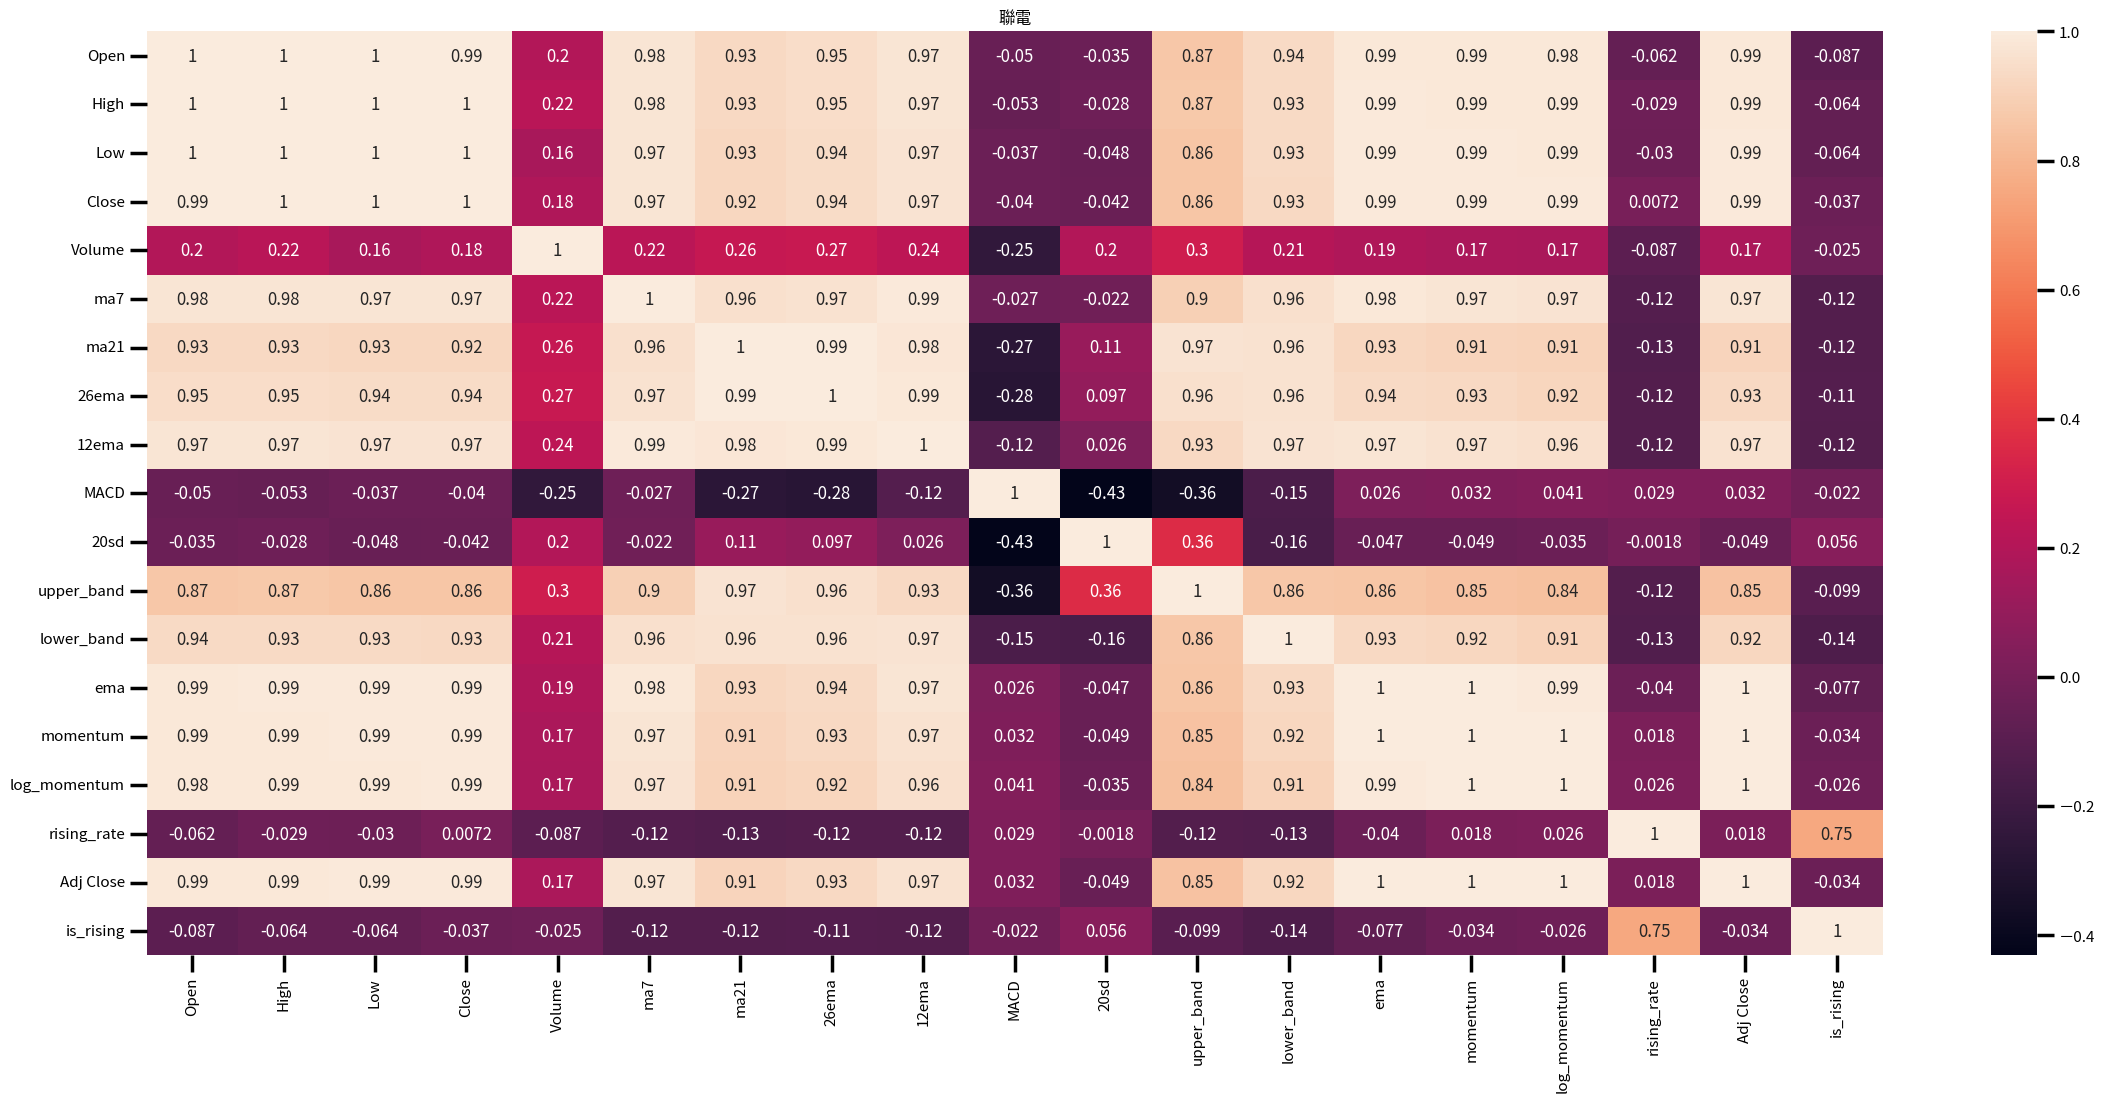

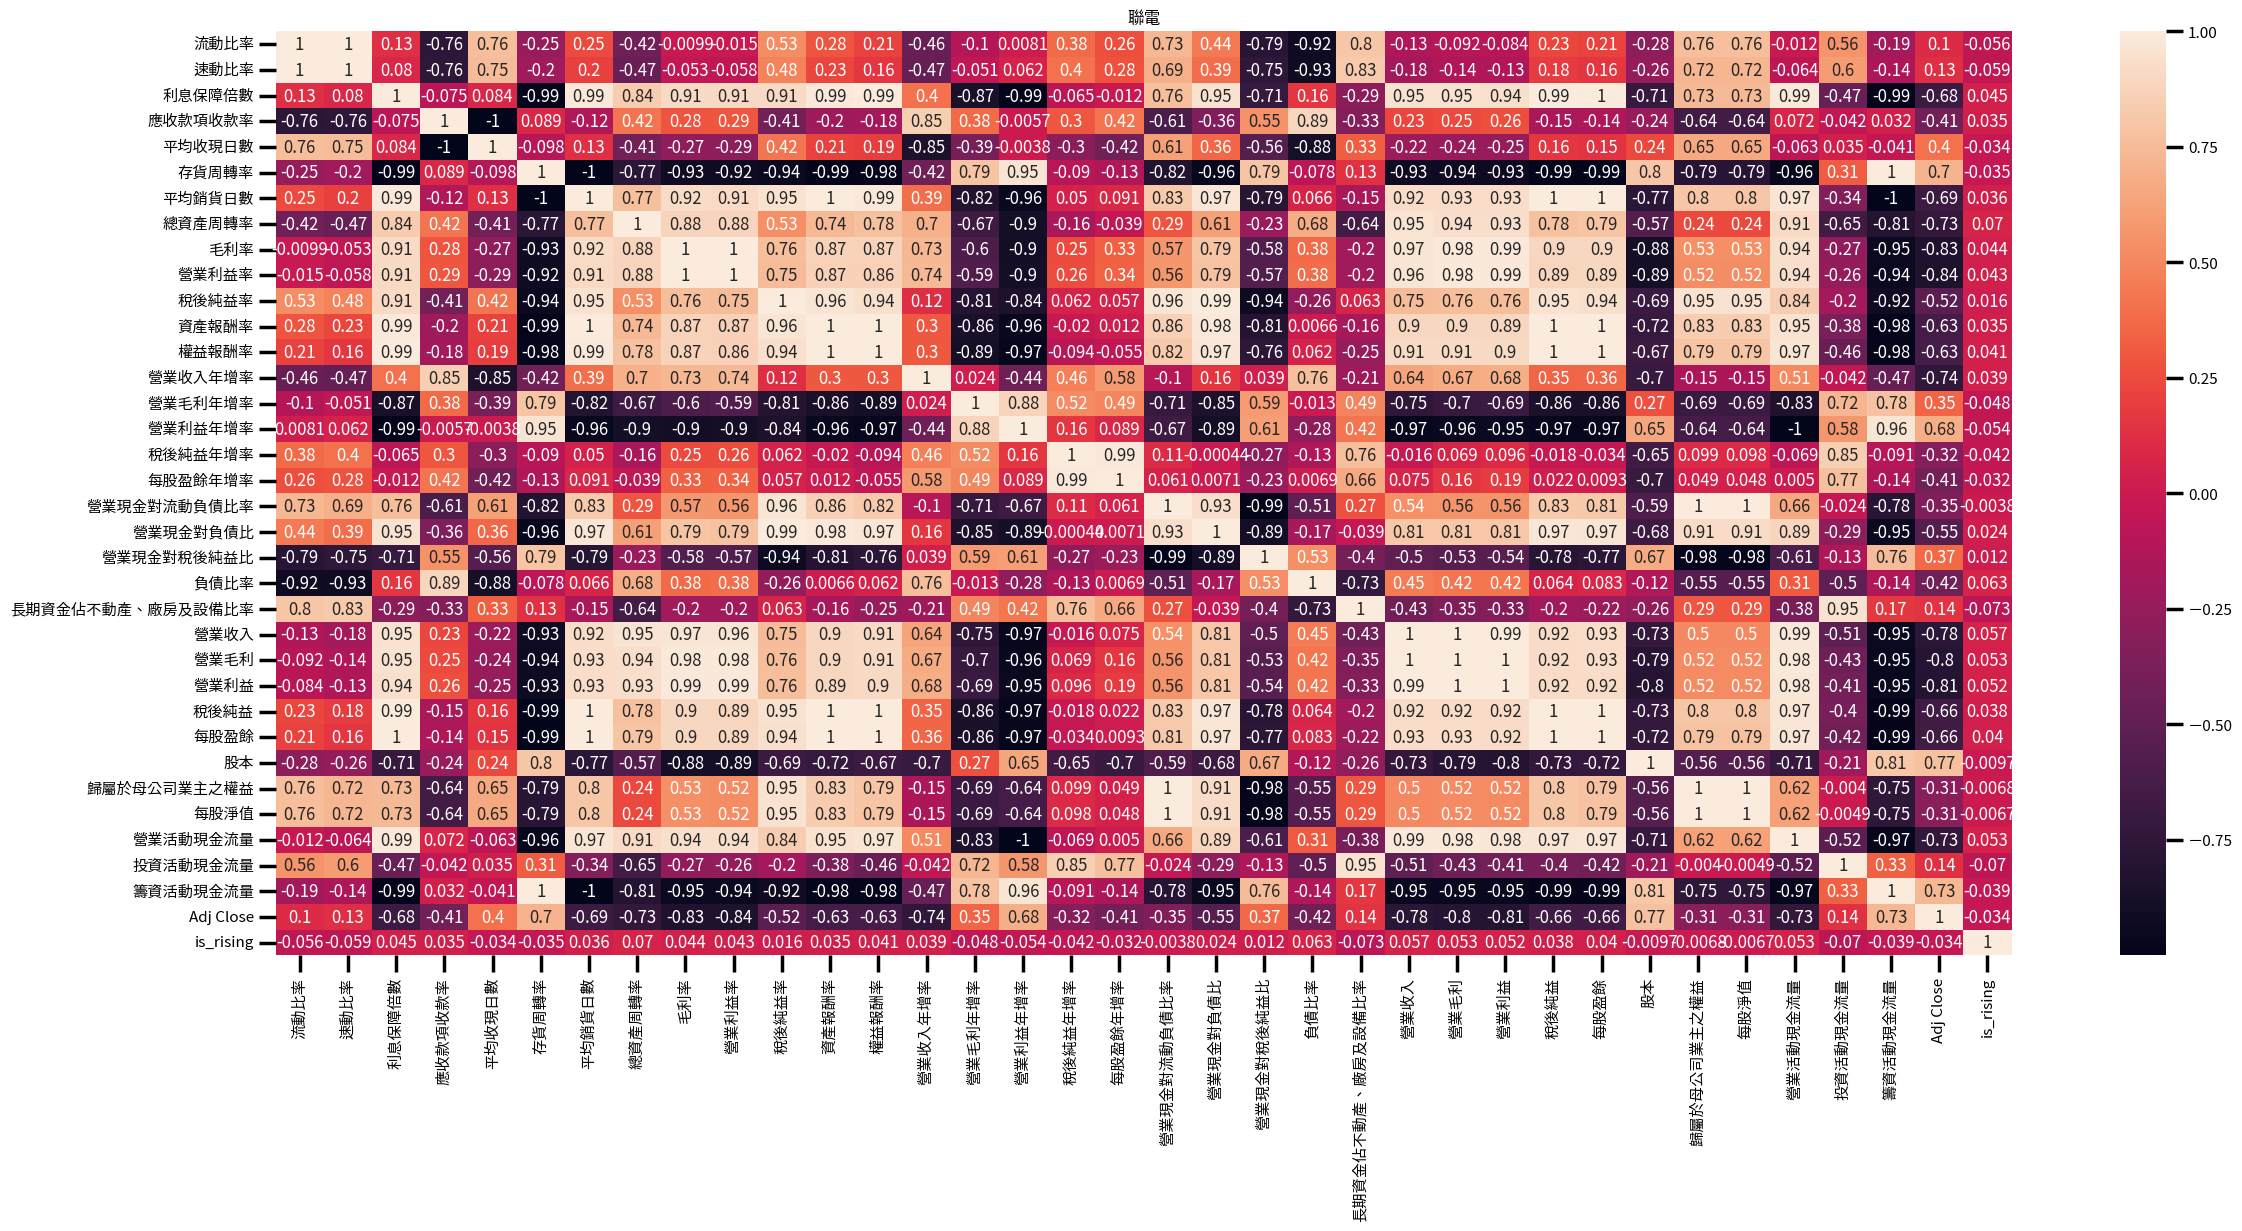

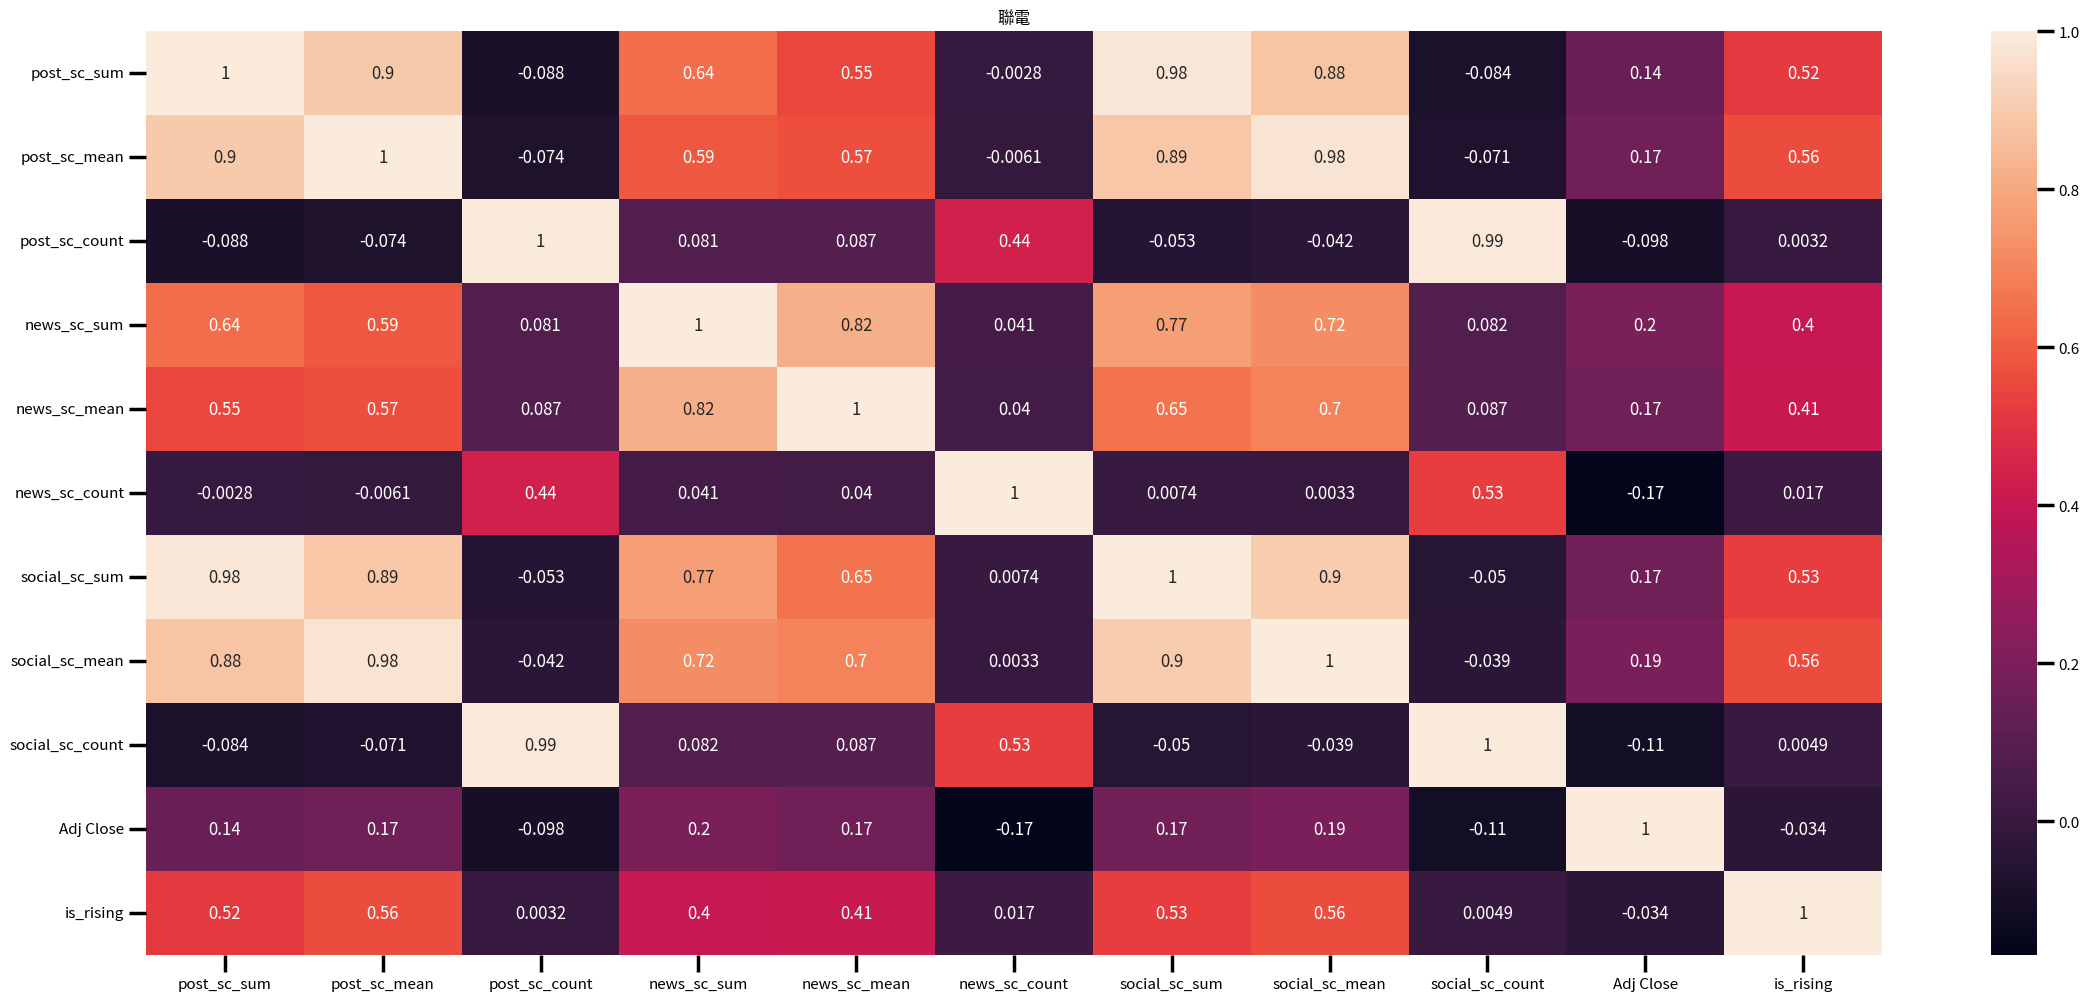

In [ ]:
c_2303.plot_corr(1)
c_2303.plot_corr(2)
c_2303.plot_corr(3)

# 訓練預測

## 股價模型

In [ ]:
config_0 = {
  'seq_length': 5,
  'epochs': 100,
  'batch_size': 16,
  'units_lstm': [50, 60, 80, 120],
  'activations': ['relu', 'relu', 'relu', 'relu'],
  'dropout_rates': [0.2, 0.3, 0.4, 0.5],
  'dense_units': 1,
  'adam_para': {
    'learning_rate': 0.001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-7
  },
  'loss': 'mean_squared_error'
}

### 2303聯電

技術面

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             14000     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_1 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 80)             45120     
                                                                 
 dropout_2 (Dropout)         (None, 5, 80)             0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

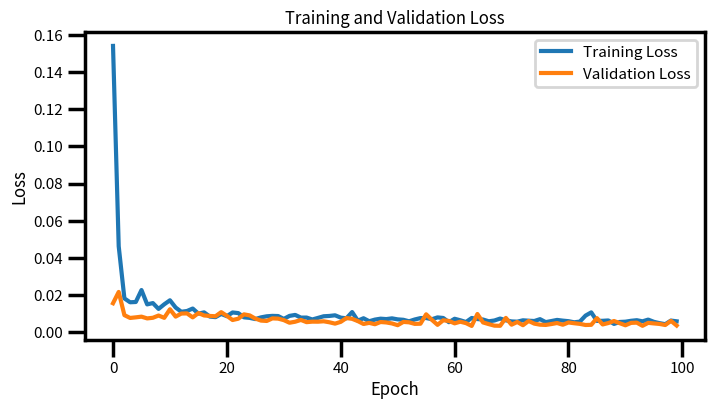

5/5 [==============================] - 1s 7ms/step


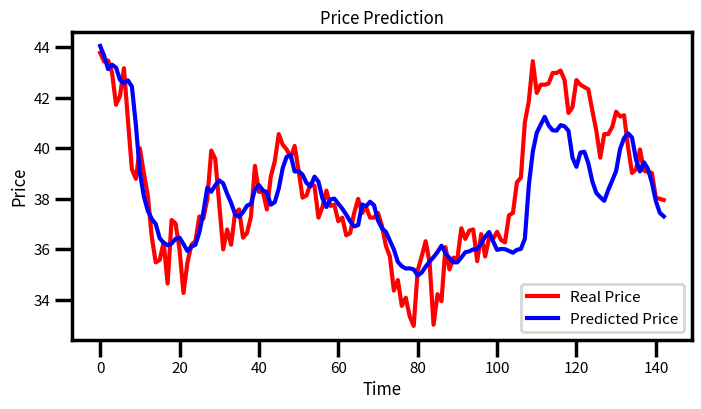

In [ ]:
stock_prediction_2303_t = StockPriceModel(c_2303.get_data(1), config=config_0, mode='price')
stock_prediction_2303_t.run()

技術面+基本面

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             20800     
                                                                 
 dropout_4 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_5 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 80)             45120     
                                                                 
 dropout_6 (Dropout)         (None, 5, 80)             0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

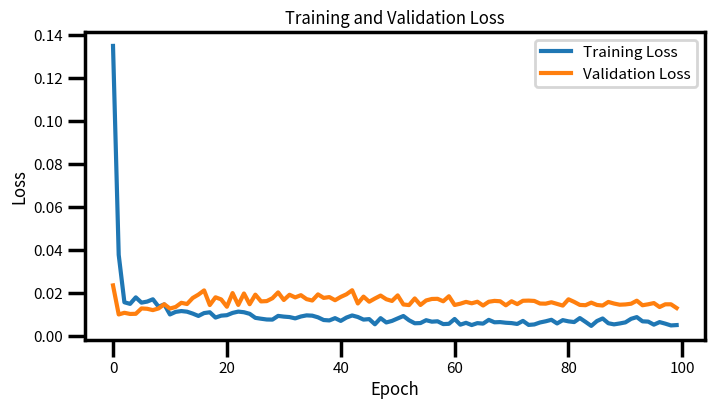

5/5 [==============================] - 1s 11ms/step


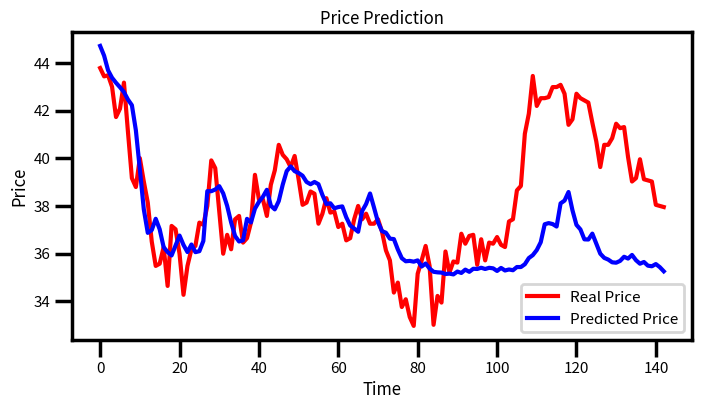

In [ ]:
stock_prediction_2303_tf = StockPriceModel(c_2303.get_data([1, 2]), config=config_0, mode='price')
stock_prediction_2303_tf.run()

技術面+情感面

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 50)             15800     
                                                                 
 dropout_8 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 60)             26640     
                                                                 
 dropout_9 (Dropout)         (None, 5, 60)             0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_10 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_11 (LSTM)              (None, 120)              

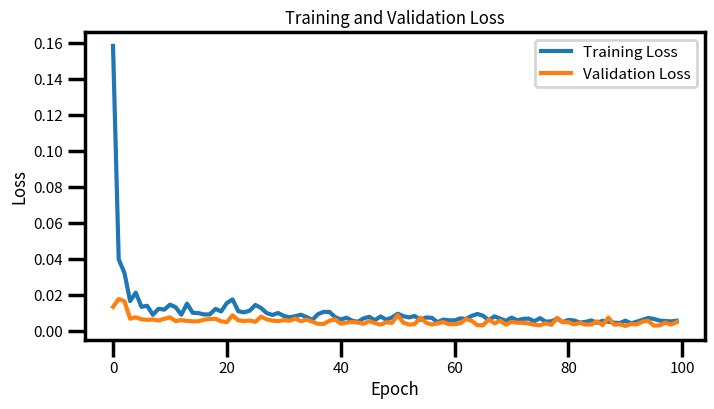

5/5 [==============================] - 1s 7ms/step


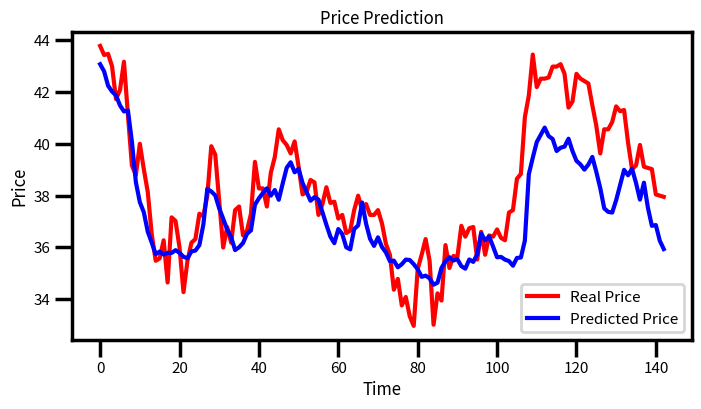

In [ ]:
stock_prediction_2303_ts = StockPriceModel(c_2303.get_data([1, 3]), config=config_0, mode='price')
stock_prediction_2303_ts.run()

技術面+基本面+情感面

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 5, 50)             22600     
                                                                 
 dropout_12 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_13 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_14 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_14 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

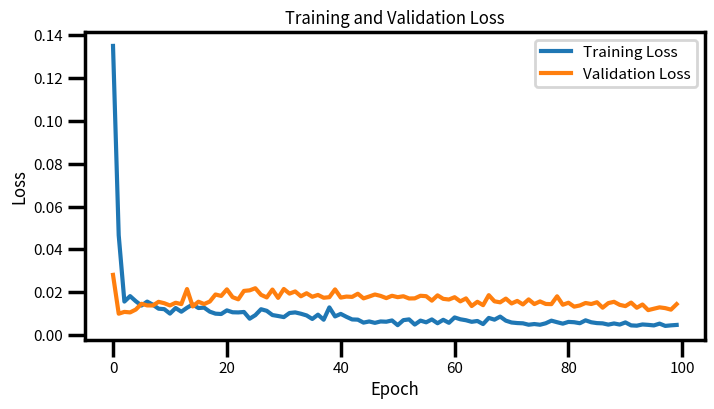

5/5 [==============================] - 1s 7ms/step


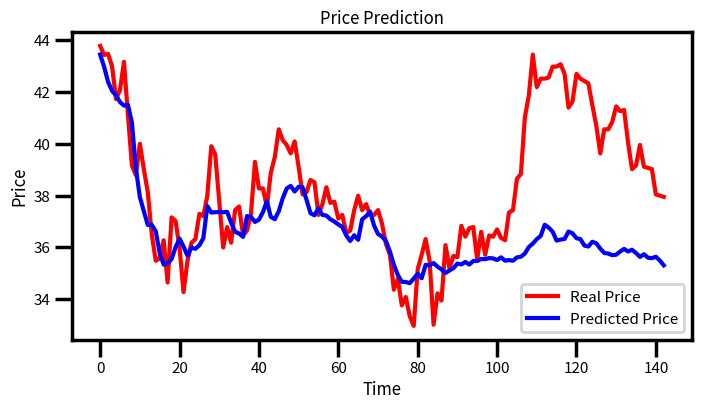

In [ ]:
stock_prediction_2303 = StockPriceModel(c_2303.get_data(), config=config_0, mode='price')
stock_prediction_2303.run()

### 3711日月光

技術面

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 50)             14000     
                                                                 
 dropout_16 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_17 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_17 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_18 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_18 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

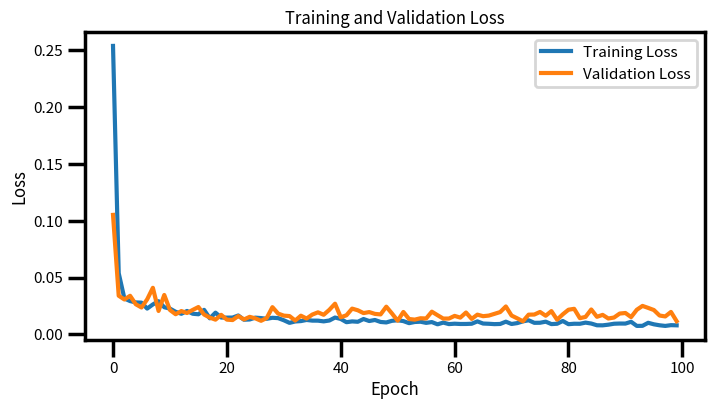

5/5 [==============================] - 1s 13ms/step


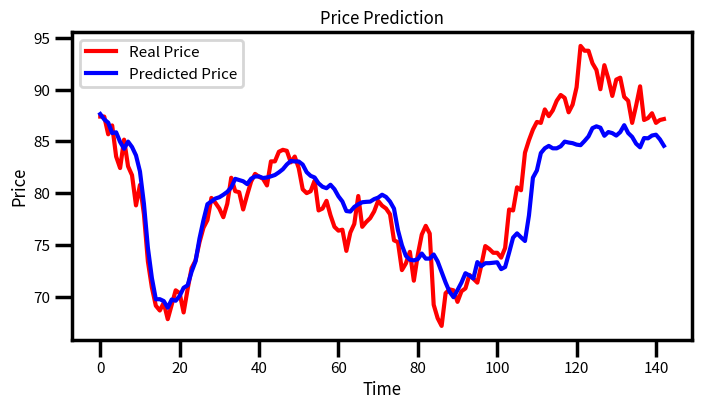

In [ ]:
stock_prediction_3711_t = StockPriceModel(c_3711.get_data(1), config=config_0, mode='price')
stock_prediction_3711_t.run()

技術面+基本面

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 5, 50)             20800     
                                                                 
 dropout_20 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_21 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_21 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_22 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_22 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_23 (LSTM)              (None, 120)              

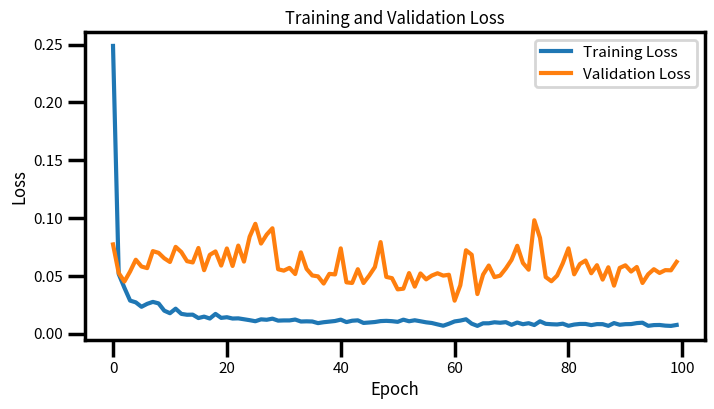

5/5 [==============================] - 1s 12ms/step


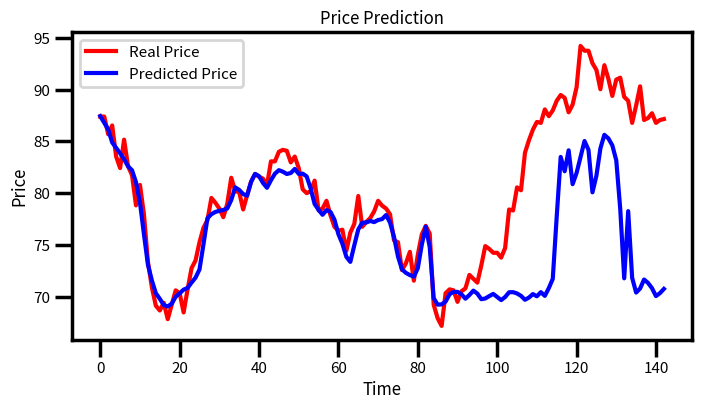

In [ ]:
stock_prediction_3711_tf = StockPriceModel(c_3711.get_data([1, 2]), config=config_0, mode='price')
stock_prediction_3711_tf.run()

技術面+情感面

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 5, 50)             15800     
                                                                 
 dropout_24 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_25 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_25 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_26 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_26 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_27 (LSTM)              (None, 120)              

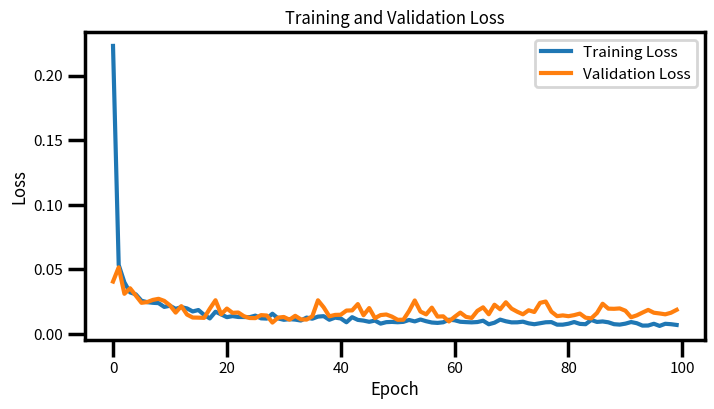

5/5 [==============================] - 1s 7ms/step


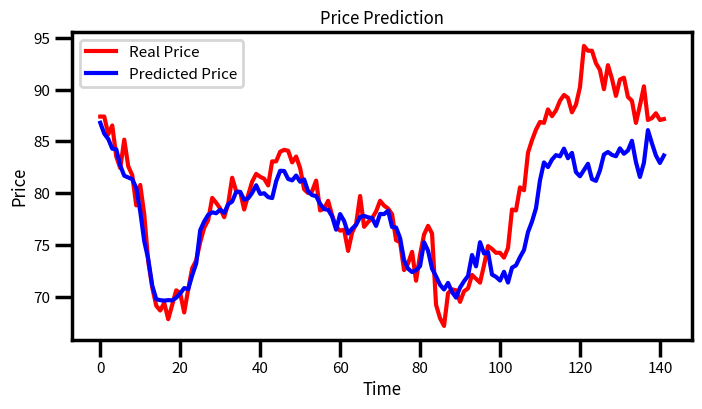

In [ ]:
stock_prediction_3711_ts = StockPriceModel(c_3711.get_data([1, 3]), config=config_0, mode='price')
stock_prediction_3711_ts.run()

技術面+基本面+情感面

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 5, 50)             22600     
                                                                 
 dropout_100 (Dropout)       (None, 5, 50)             0         
                                                                 
 lstm_101 (LSTM)             (None, 5, 60)             26640     
                                                                 
 dropout_101 (Dropout)       (None, 5, 60)             0         
                                                                 
 lstm_102 (LSTM)             (None, 5, 80)             45120     
                                                                 
 dropout_102 (Dropout)       (None, 5, 80)             0         
                                                                 
 lstm_103 (LSTM)             (None, 120)             

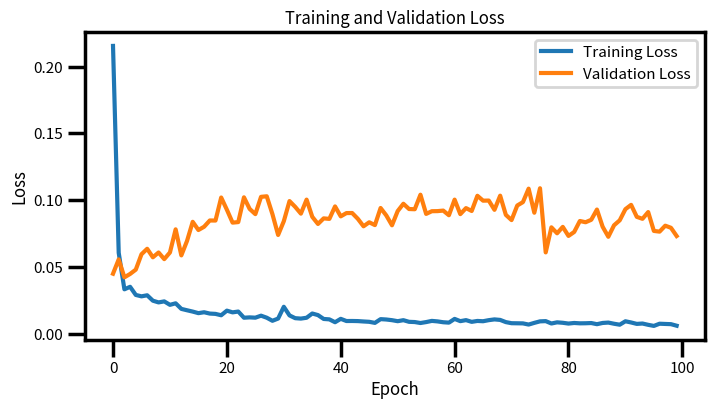

5/5 [==============================] - 1s 8ms/step


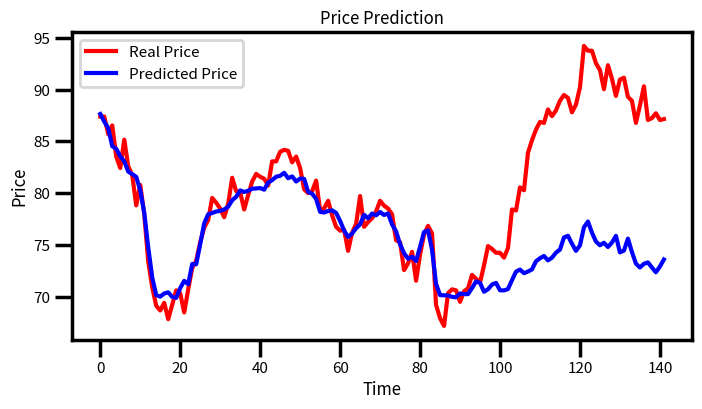

In [ ]:
stock_prediction_3711 = StockPriceModel(c_3711.get_data(), config=config_0, mode='price')
stock_prediction_3711.run()

### 2308台達電

技術面

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 5, 50)             14000     
                                                                 
 dropout_32 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_33 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_33 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_34 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_34 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_35 (LSTM)              (None, 120)              

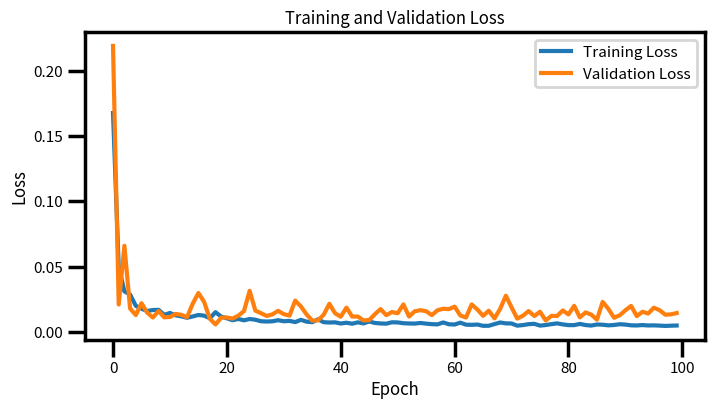

5/5 [==============================] - 1s 10ms/step


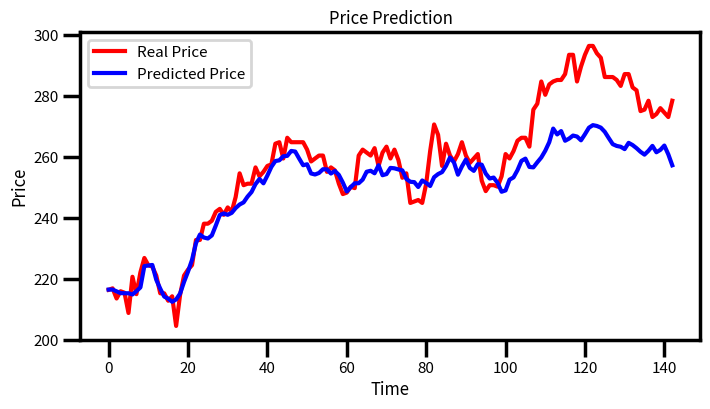

In [ ]:
stock_prediction_2308_t = StockPriceModel(c_2308.get_data(1), config=config_0, mode='price')
stock_prediction_2308_t.run()

技術面+基本面

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 5, 50)             20800     
                                                                 
 dropout_36 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_37 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_37 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_38 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_38 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_39 (LSTM)              (None, 120)              

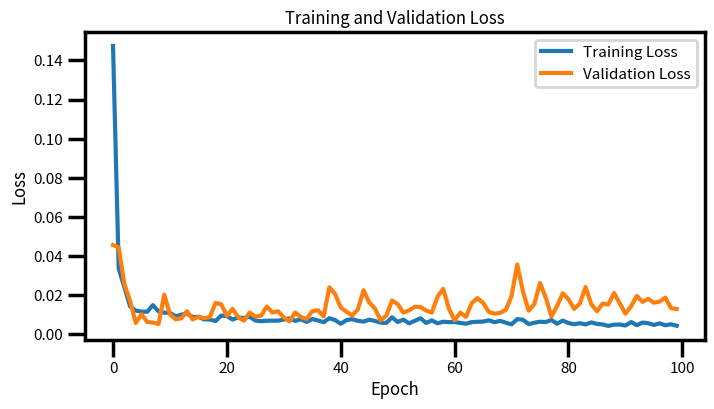

5/5 [==============================] - 1s 11ms/step


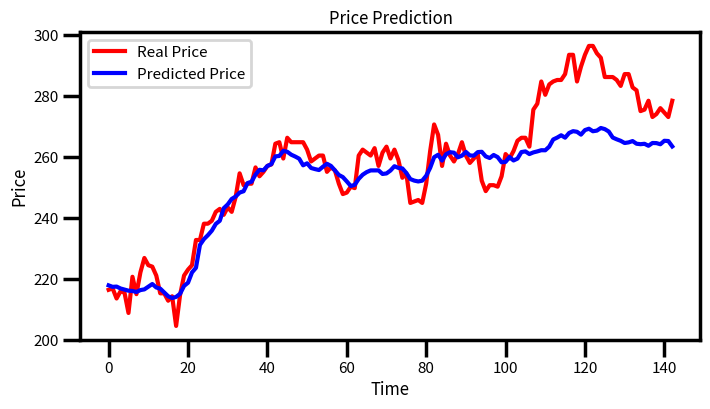

In [ ]:
stock_prediction_2308_tf = StockPriceModel(c_2308.get_data([1, 2]), config=config_0, mode='price')
stock_prediction_2308_tf.run()

技術面+情感面

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 50)             15800     
                                                                 
 dropout_40 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_41 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_41 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_42 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_42 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_43 (LSTM)              (None, 120)             

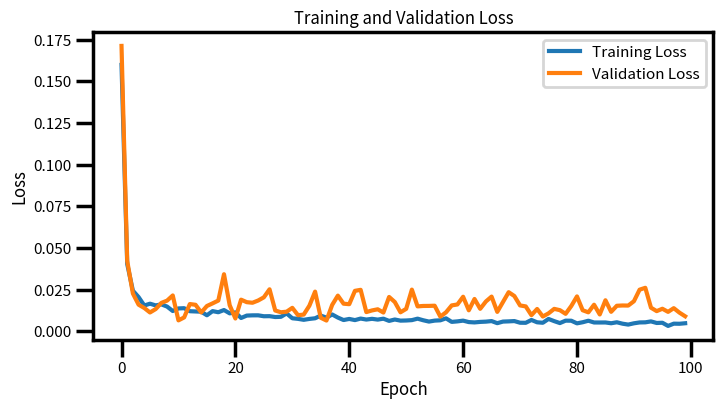

5/5 [==============================] - 1s 8ms/step


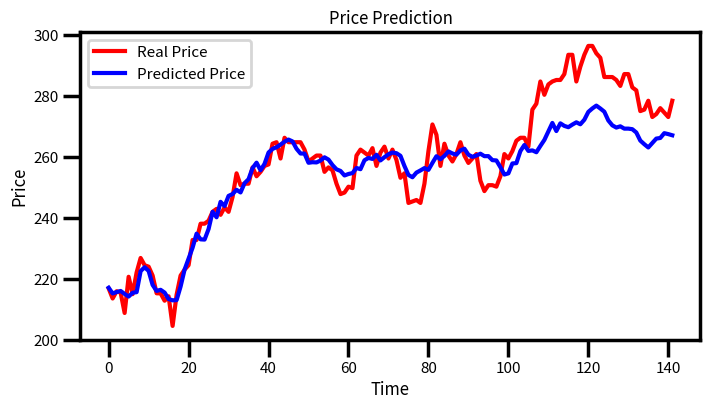

In [ ]:
stock_prediction_2308_ts = StockPriceModel(c_2308.get_data([1, 3]), config=config_0, mode='price')
stock_prediction_2308_ts.run()

技術面+基本面+情感面

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 5, 50)             22600     
                                                                 
 dropout_44 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_45 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_45 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_46 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_46 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_47 (LSTM)              (None, 120)             

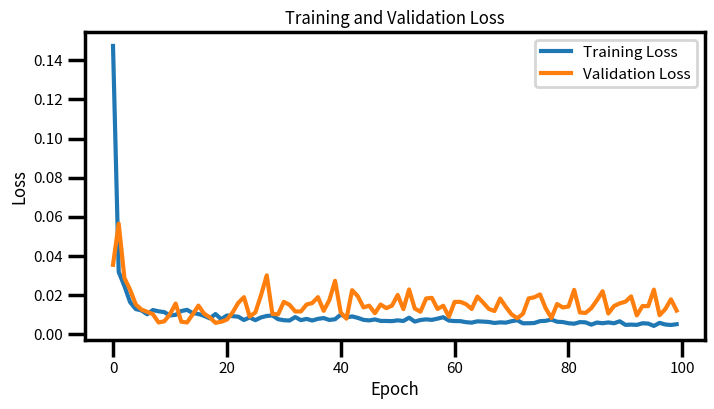

5/5 [==============================] - 1s 9ms/step


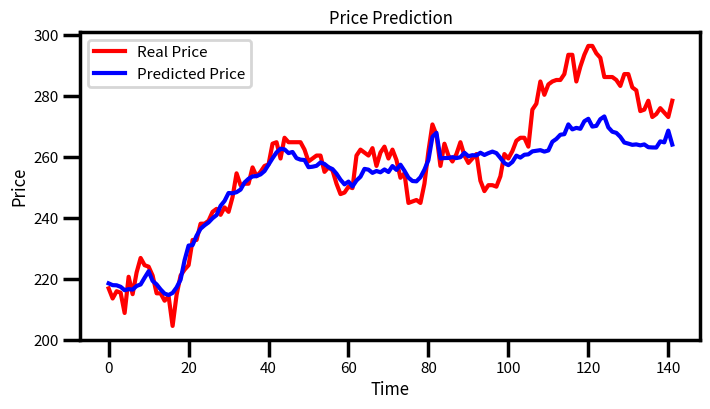

In [ ]:
stock_prediction_2308 = StockPriceModel(c_2308.get_data(), config=config_0, mode='price')
stock_prediction_2308.run()

### 2330台積電

技術面

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 5, 50)             14000     
                                                                 
 dropout_48 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_49 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_49 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_50 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_50 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_51 (LSTM)              (None, 120)             

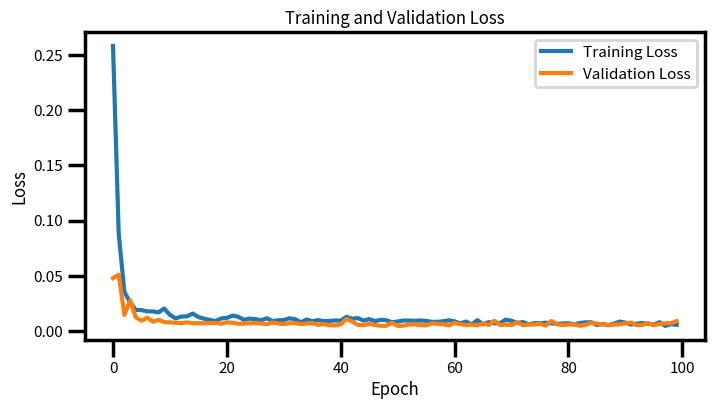

5/5 [==============================] - 1s 11ms/step


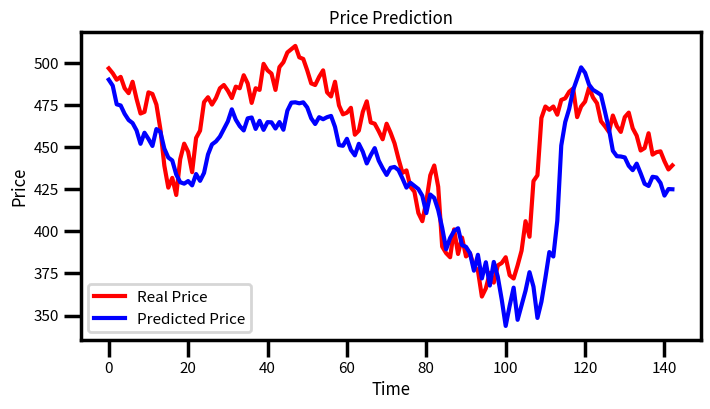

In [ ]:
stock_prediction_2330_t = StockPriceModel(c_2330.get_data(1), config=config_0, mode='price')
stock_prediction_2330_t.run()

技術面+基本面

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 5, 50)             20800     
                                                                 
 dropout_52 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_53 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_53 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_54 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_54 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_55 (LSTM)              (None, 120)             

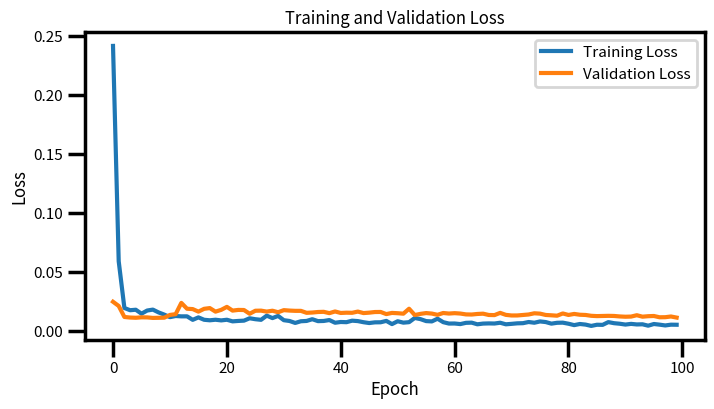

5/5 [==============================] - 1s 8ms/step


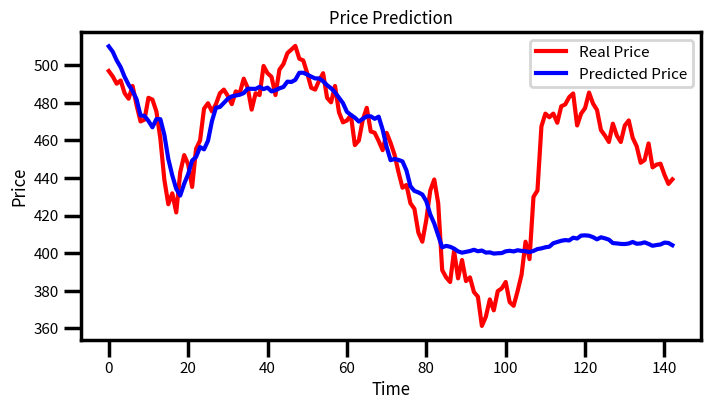

In [ ]:
stock_prediction_2330_tf = StockPriceModel(c_2330.get_data([1, 2]), config=config_0, mode='price')
stock_prediction_2330_tf.run()

技術面+情感面

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 5, 50)             15800     
                                                                 
 dropout_56 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_57 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_57 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_58 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_58 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_59 (LSTM)              (None, 120)             

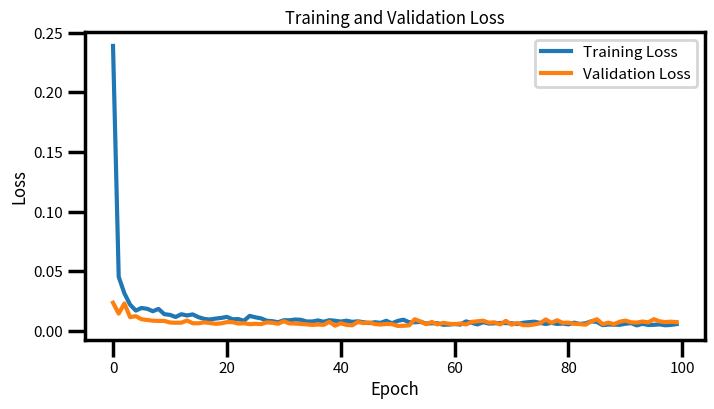

5/5 [==============================] - 1s 8ms/step


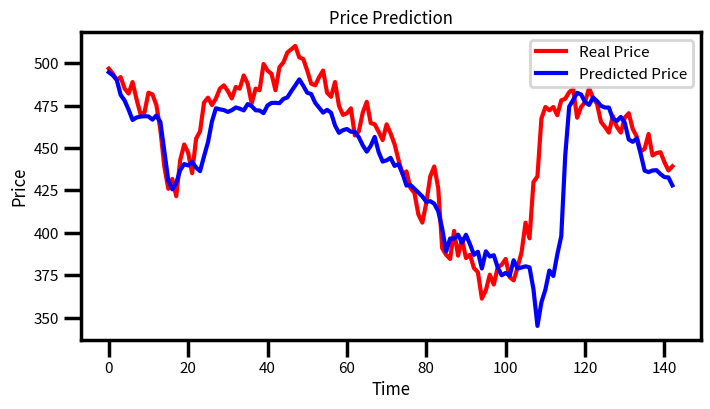

In [ ]:
stock_prediction_2330_ts = StockPriceModel(c_2330.get_data([1, 3]), config=config_0, mode='price')
stock_prediction_2330_ts.run()

技術面+基本面+情感面

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 5, 50)             22600     
                                                                 
 dropout_60 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_61 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_61 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_62 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_62 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_63 (LSTM)              (None, 120)             

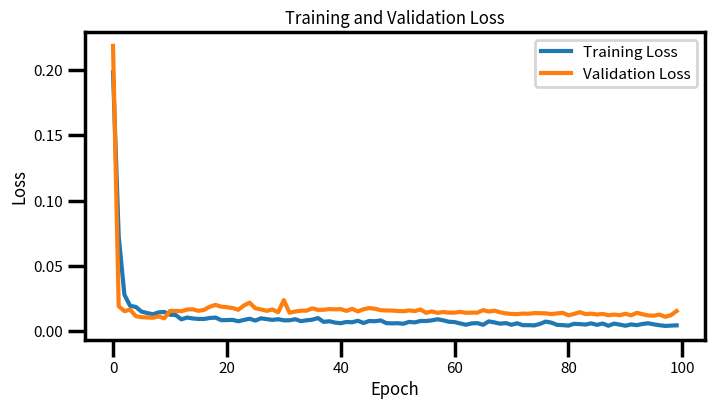

5/5 [==============================] - 1s 11ms/step


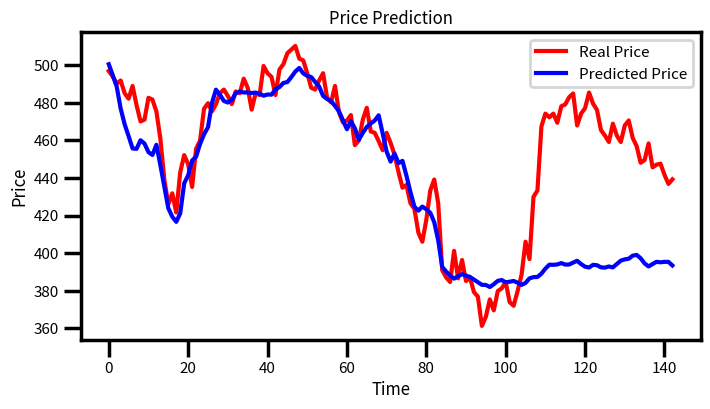

In [ ]:
stock_prediction_2330 = StockPriceModel(c_2330.get_data(), config=config_0, mode='price')
stock_prediction_2330.run()

### 2454聯發科

技術面

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 5, 50)             14000     
                                                                 
 dropout_64 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_65 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_65 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_66 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_66 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_67 (LSTM)              (None, 120)             

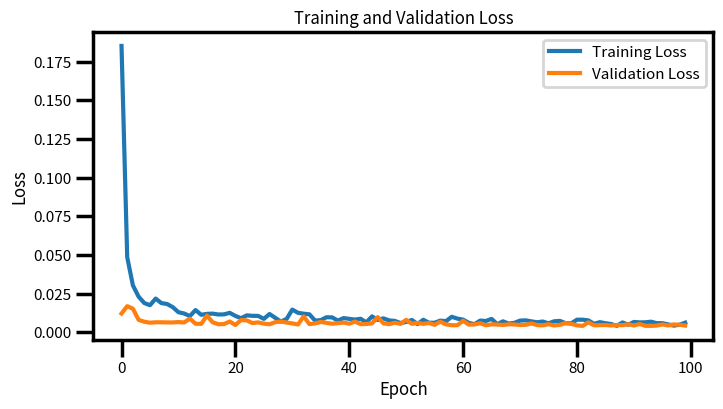

5/5 [==============================] - 1s 7ms/step


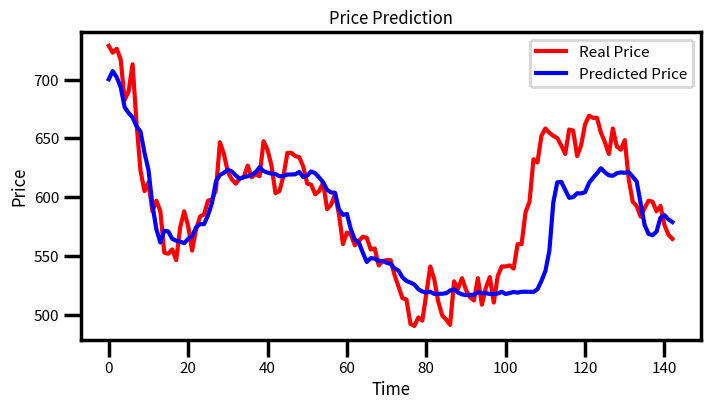

In [ ]:
stock_prediction_2454_t = StockPriceModel(c_2454.get_data(1), config=config_0, mode='price')
stock_prediction_2454_t.run()

技術面+基本面

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 5, 50)             20800     
                                                                 
 dropout_68 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_69 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_69 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_70 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_70 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_71 (LSTM)              (None, 120)             

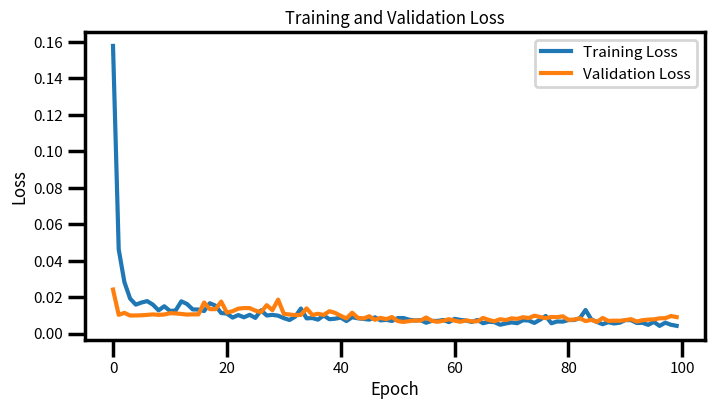

5/5 [==============================] - 1s 7ms/step


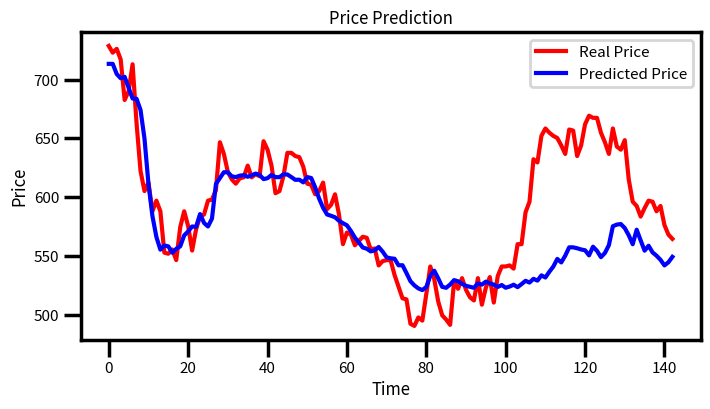

In [ ]:
stock_prediction_2454_tf = StockPriceModel(c_2454.get_data([1, 2]), config=config_0, mode='price')
stock_prediction_2454_tf.run()

技術面+情感面

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_72 (LSTM)              (None, 5, 50)             15800     
                                                                 
 dropout_72 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_73 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_73 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_74 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_74 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_75 (LSTM)              (None, 120)             

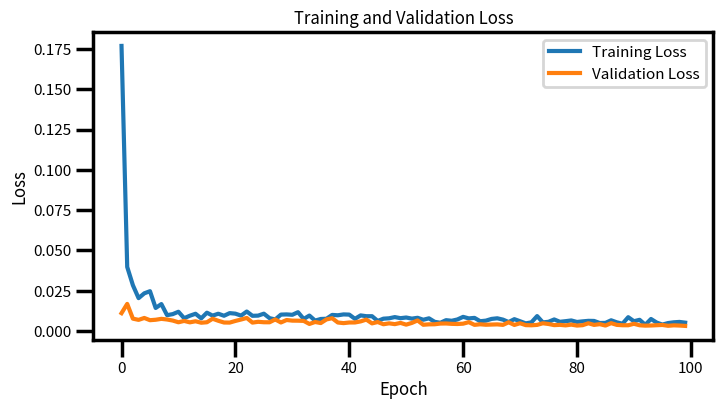

5/5 [==============================] - 1s 10ms/step


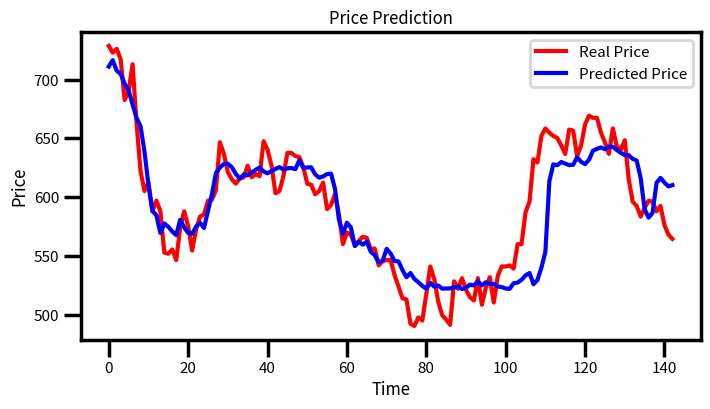

In [ ]:
stock_prediction_2454_ts = StockPriceModel(c_2454.get_data([1, 3]), config=config_0, mode='price')
stock_prediction_2454_ts.run()

技術面+基本面+情感面

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_76 (LSTM)              (None, 5, 50)             22600     
                                                                 
 dropout_76 (Dropout)        (None, 5, 50)             0         
                                                                 
 lstm_77 (LSTM)              (None, 5, 60)             26640     
                                                                 
 dropout_77 (Dropout)        (None, 5, 60)             0         
                                                                 
 lstm_78 (LSTM)              (None, 5, 80)             45120     
                                                                 
 dropout_78 (Dropout)        (None, 5, 80)             0         
                                                                 
 lstm_79 (LSTM)              (None, 120)             

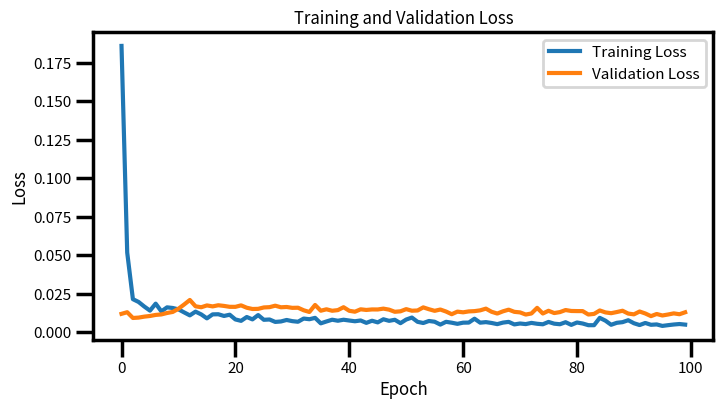

5/5 [==============================] - 1s 8ms/step


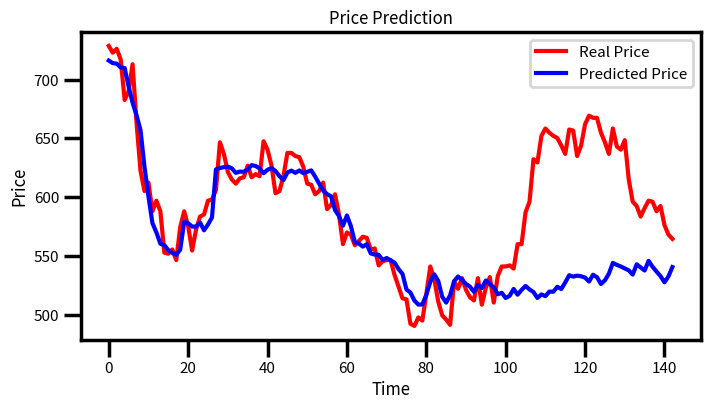

In [ ]:
stock_prediction_2454 = StockPriceModel(c_2454.get_data(), config=config_0, mode='price')
stock_prediction_2454.run()

## 漲跌模型

In [ ]:
config = {
  'seq_length': 5,
  'epochs': 100,
  'batch_size': 16,
  'units_lstm': [80],
  'activations': ['tanh'],
  'dropout_rates': [0.3],
  'dense_units': 1,
  'adam_para': {
    'learning_rate': 0.0001,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-7
  },
  'loss': 'binary_crossentropy',
}

### 2303聯電

技術面

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80)                32000     
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


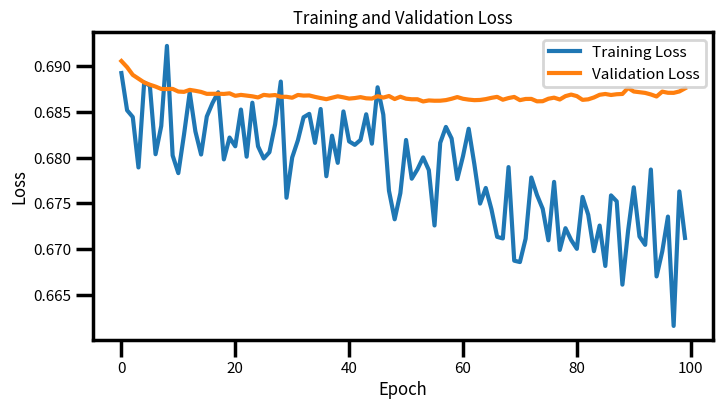

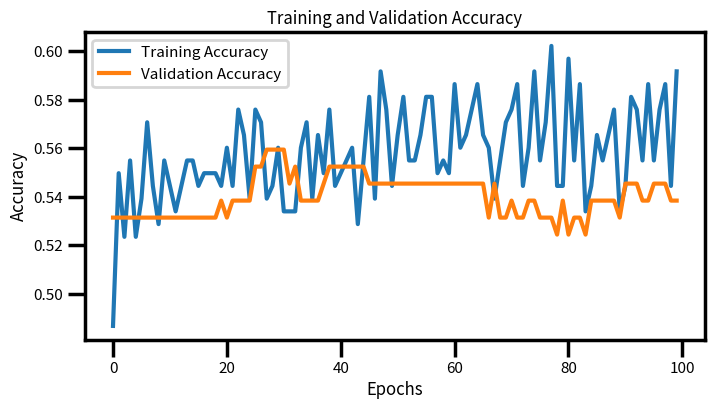

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.5384615384615384


In [ ]:
is_rising_prediction_2303_t = StockPriceModel(c_2303.get_data(1), config=config, mode='is_rising')
is_rising_prediction_2303_t.run()

技術面+基本面

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 80)                42880     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 42961 (167.82 KB)
Trainable params: 42961 (167.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


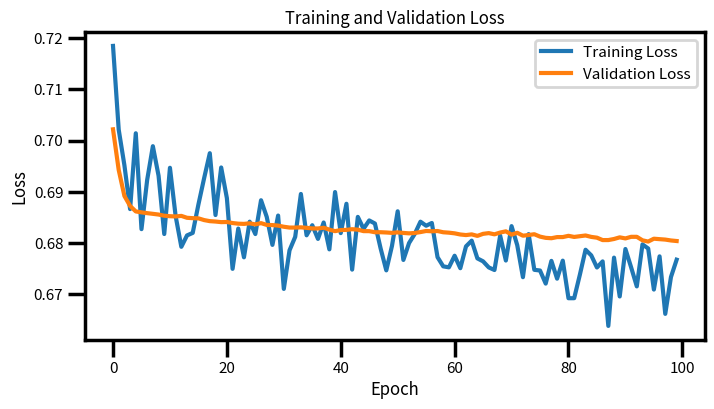

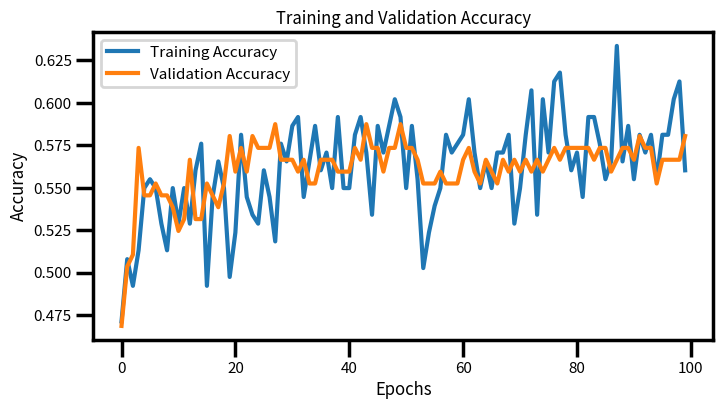

5/5 [==============================] - 1s 3ms/step
Accuracy: 0.5804195804195804


In [ ]:
is_rising_prediction_2303_tf = StockPriceModel(c_2303.get_data([1, 2]), config=config, mode='is_rising')
is_rising_prediction_2303_tf.run()

技術面+情感面

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 80)                34880     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 34961 (136.57 KB)
Trainable params: 34961 (136.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


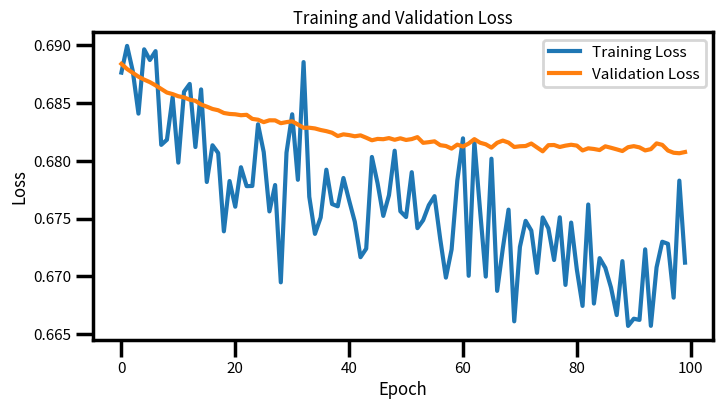

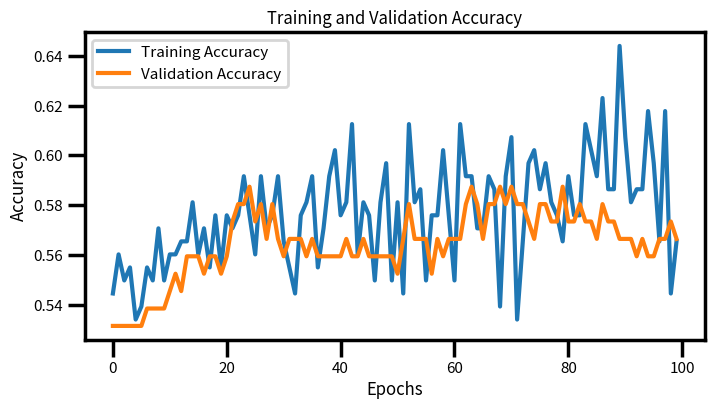

5/5 [==============================] - 1s 4ms/step
Accuracy: 0.5664335664335665


In [ ]:
is_rising_prediction_2303_ts = StockPriceModel(c_2303.get_data([1, 3]), config=config, mode='is_rising')
is_rising_prediction_2303_ts.run()

技術面+基本面+情感面

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 80)                45760     
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                                 
Total params: 45841 (179.07 KB)
Trainable params: 45841 (179.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


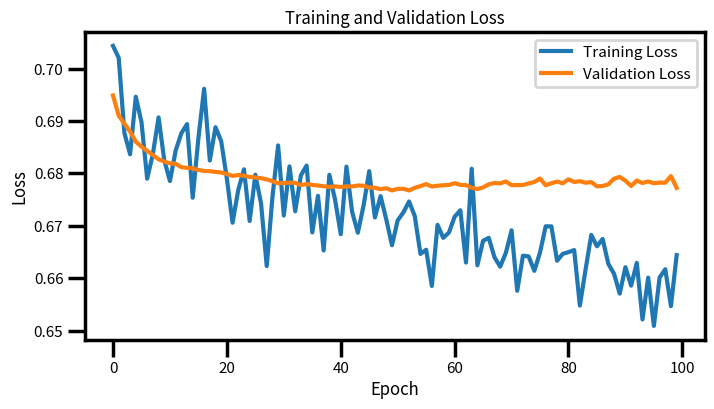

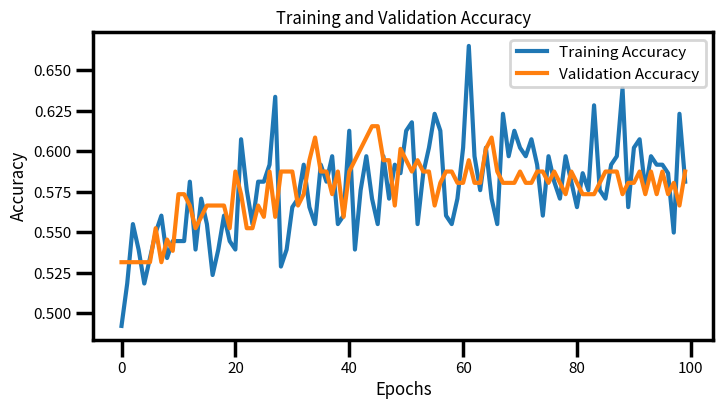

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.5874125874125874


In [ ]:
is_rising_prediction_2303 = StockPriceModel(c_2303.get_data(), config=config, mode='is_rising')
is_rising_prediction_2303.run()

### 3711日月光

技術面

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 80)                32000     
                                                                 
 dropout_4 (Dropout)         (None, 80)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 81        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


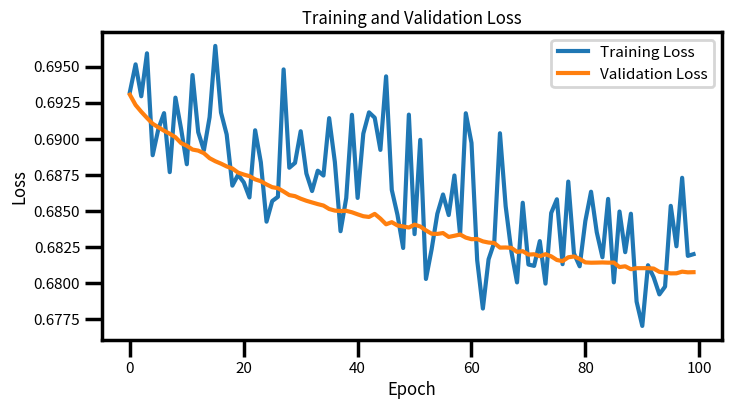

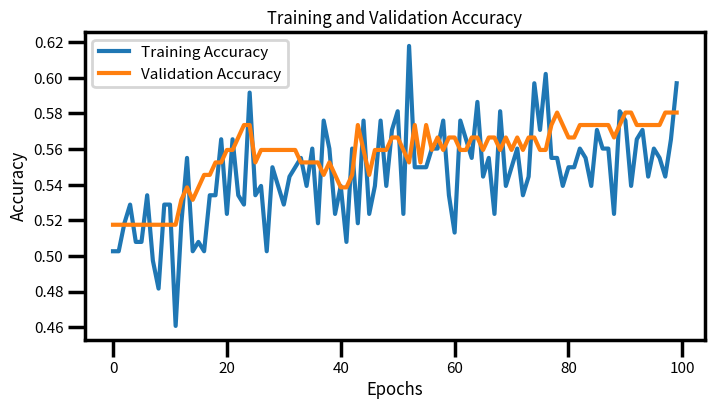

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.5804195804195804


In [ ]:
is_rising_prediction_3711_t = StockPriceModel(c_3711.get_data(1), config=config, mode='is_rising')
is_rising_prediction_3711_t.run()

技術面+基本面

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 80)                42880     
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 81        
                                                                 
Total params: 42961 (167.82 KB)
Trainable params: 42961 (167.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


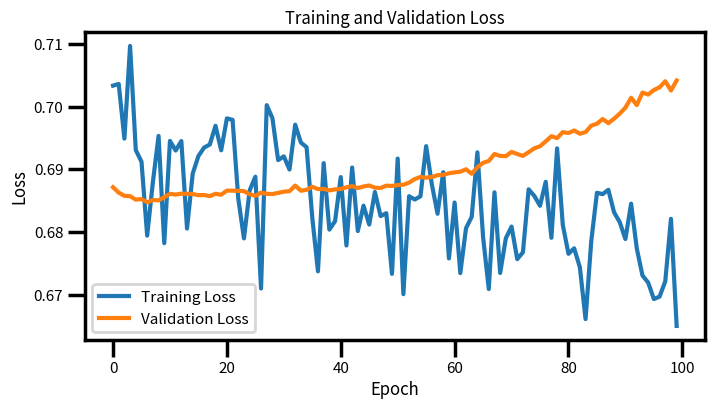

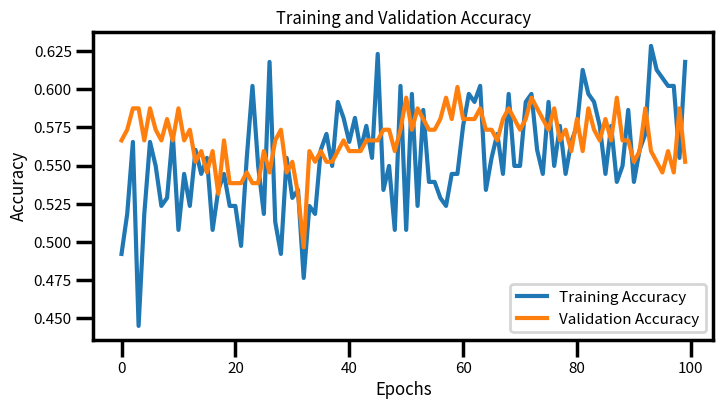

5/5 [==============================] - 1s 3ms/step
Accuracy: 0.5524475524475524


In [ ]:
is_rising_prediction_3711_tf = StockPriceModel(c_3711.get_data([1, 2]), config=config, mode='is_rising')
is_rising_prediction_3711_tf.run()

技術面+情感面

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80)                34880     
                                                                 
 dropout_6 (Dropout)         (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 81        
                                                                 
Total params: 34961 (136.57 KB)
Trainable params: 34961 (136.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


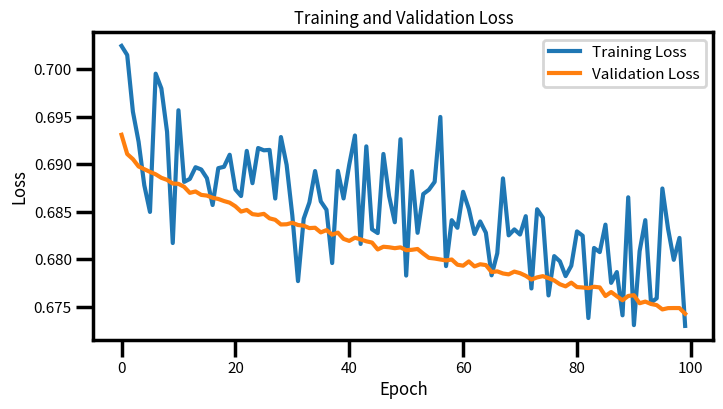

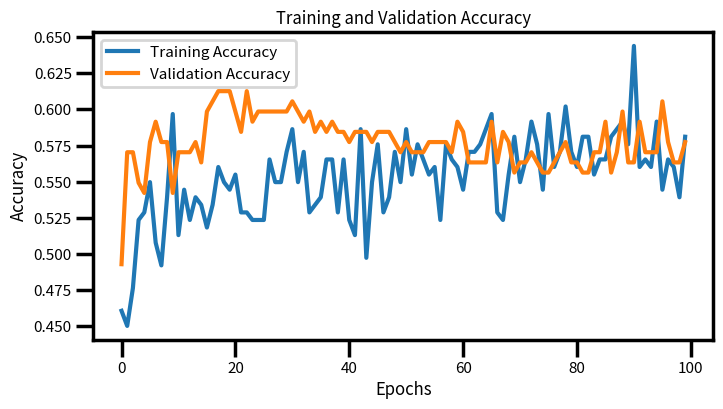

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.5774647887323944


In [ ]:
is_rising_prediction_3711_ts = StockPriceModel(c_3711.get_data([1, 3]), config=config, mode='is_rising')
is_rising_prediction_3711_ts.run()

技術面+基本面+情感面

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 80)                45760     
                                                                 
 dropout_7 (Dropout)         (None, 80)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 81        
                                                                 
Total params: 45841 (179.07 KB)
Trainable params: 45841 (179.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


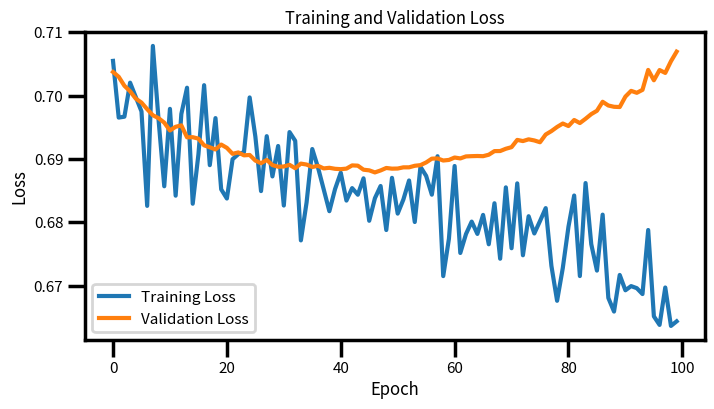

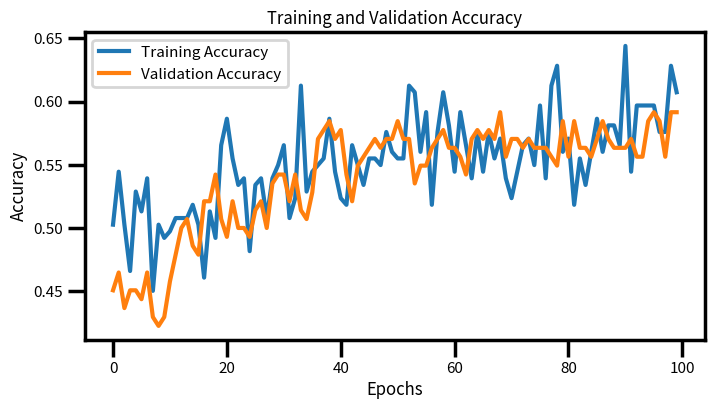

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.5915492957746479


In [ ]:
is_rising_prediction_3711 = StockPriceModel(c_3711.get_data(), config=config, mode='is_rising')
is_rising_prediction_3711.run()

### 2308台達電

技術面

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 80)                32000     
                                                                 
 dropout_20 (Dropout)        (None, 80)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 81        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


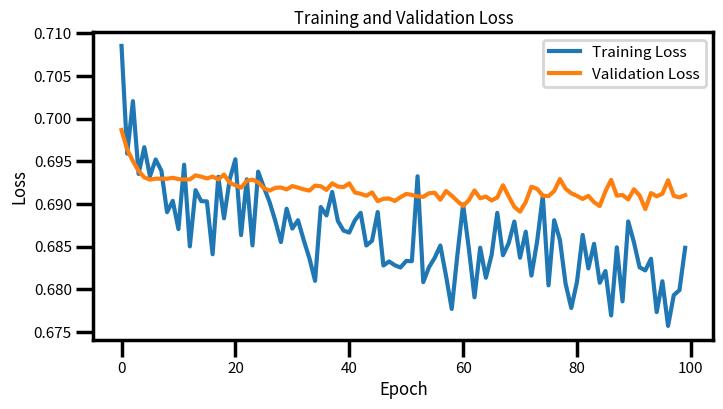

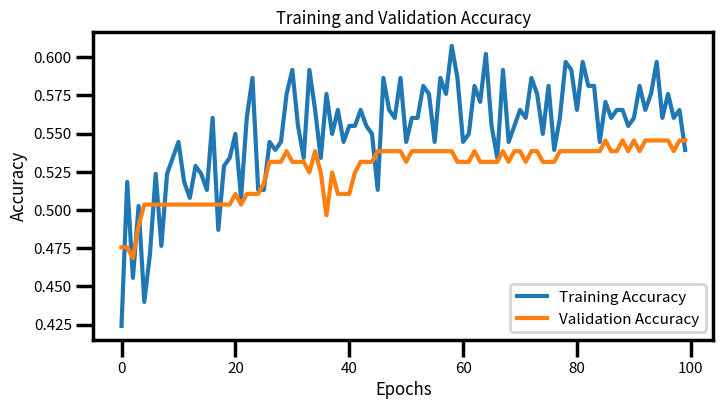

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.5454545454545454


In [ ]:
is_rising_prediction_2308_t = StockPriceModel(c_2308.get_data(1), config=config, mode='is_rising')
is_rising_prediction_2308_t.run()

技術面+基本面

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 80)                42880     
                                                                 
 dropout_21 (Dropout)        (None, 80)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 81        
                                                                 
Total params: 42961 (167.82 KB)
Trainable params: 42961 (167.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


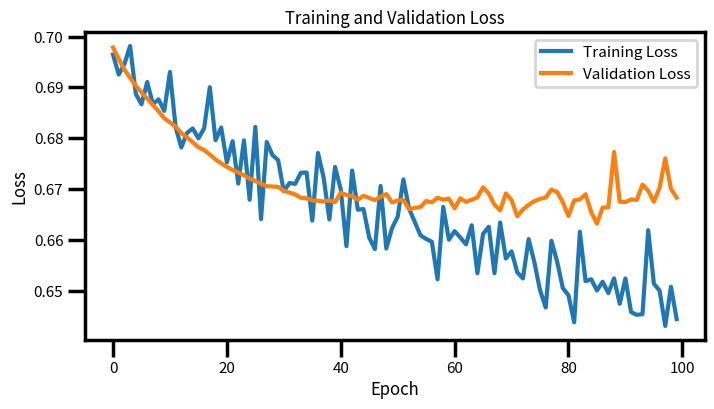

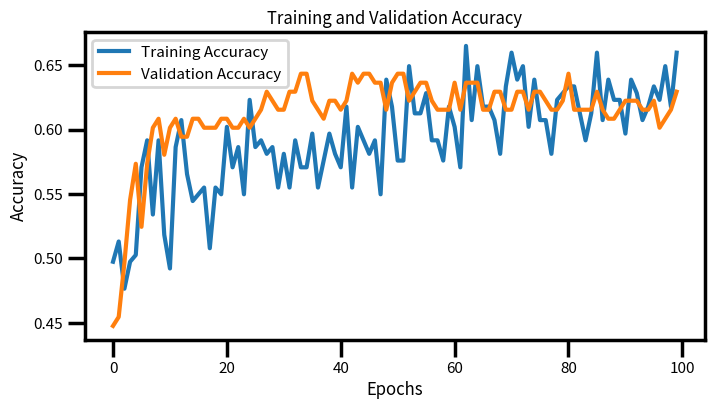

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.6293706293706294


In [ ]:
is_rising_prediction_2308_tf = StockPriceModel(c_2308.get_data([1, 2]), config=config, mode='is_rising')
is_rising_prediction_2308_tf.run()

技術面+情感面

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 80)                34880     
                                                                 
 dropout_22 (Dropout)        (None, 80)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 81        
                                                                 
Total params: 34961 (136.57 KB)
Trainable params: 34961 (136.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


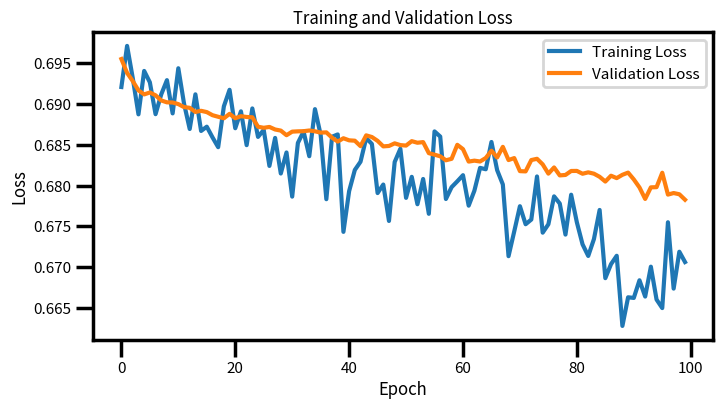

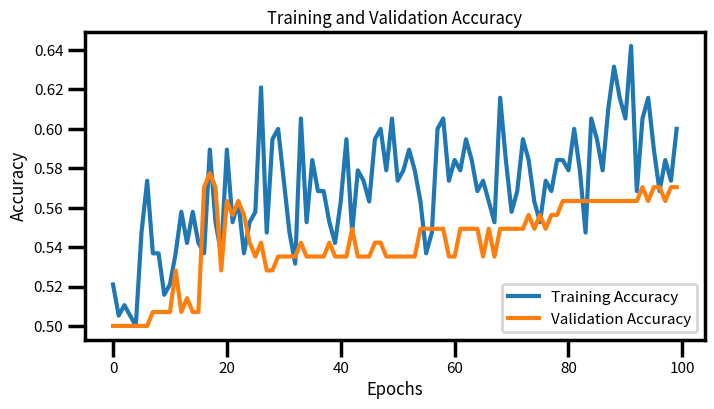

5/5 [==============================] - 1s 6ms/step
Accuracy: 0.5704225352112676


In [ ]:
is_rising_prediction_2308_ts = StockPriceModel(c_2308.get_data([1, 3]), config=config, mode='is_rising')
is_rising_prediction_2308_ts.run()

技術面+基本面+情感面

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 80)                45760     
                                                                 
 dropout_23 (Dropout)        (None, 80)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 81        
                                                                 
Total params: 45841 (179.07 KB)
Trainable params: 45841 (179.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


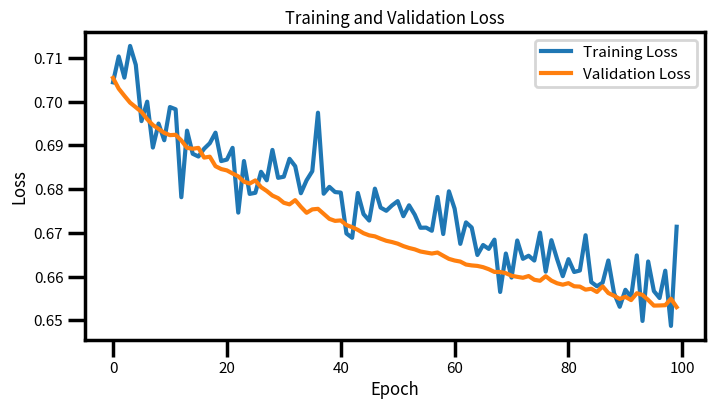

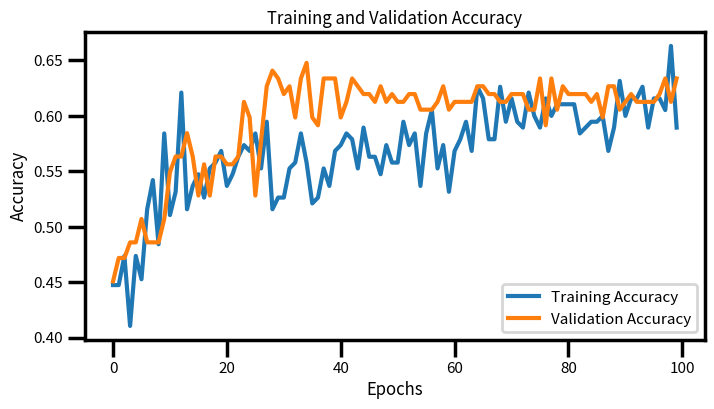

5/5 [==============================] - 1s 4ms/step
Accuracy: 0.6338028169014085


In [ ]:
is_rising_prediction_2308 = StockPriceModel(c_2308.get_data(), config=config, mode='is_rising')
is_rising_prediction_2308.run()

### 2330台積電

技術面

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 80)                32000     
                                                                 
 dropout_12 (Dropout)        (None, 80)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 81        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


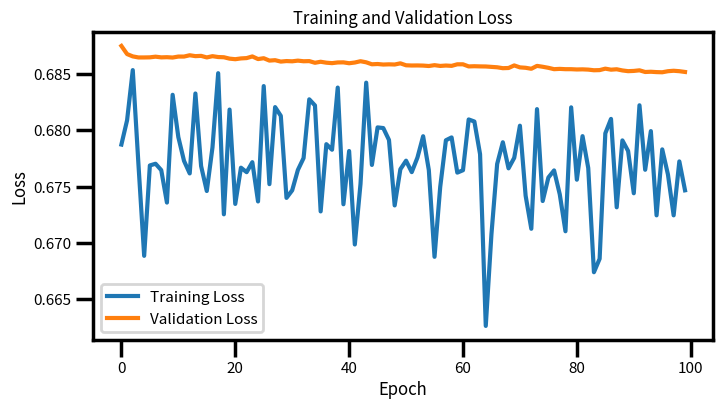

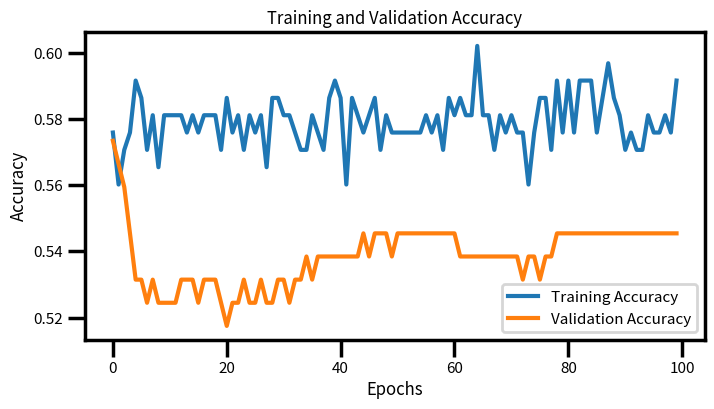

5/5 [==============================] - 1s 4ms/step
Accuracy: 0.5454545454545454


In [ ]:
is_rising_prediction_2330_t = StockPriceModel(c_2330.get_data(1), config=config, mode='is_rising')
is_rising_prediction_2330_t.run()

技術面+基本面

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 80)                42880     
                                                                 
 dropout_13 (Dropout)        (None, 80)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 81        
                                                                 
Total params: 42961 (167.82 KB)
Trainable params: 42961 (167.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


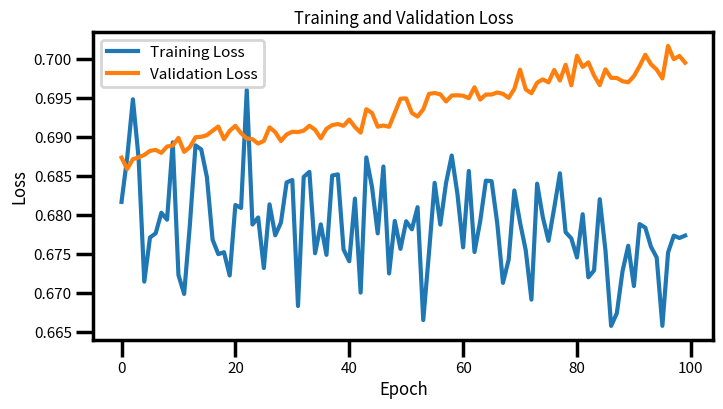

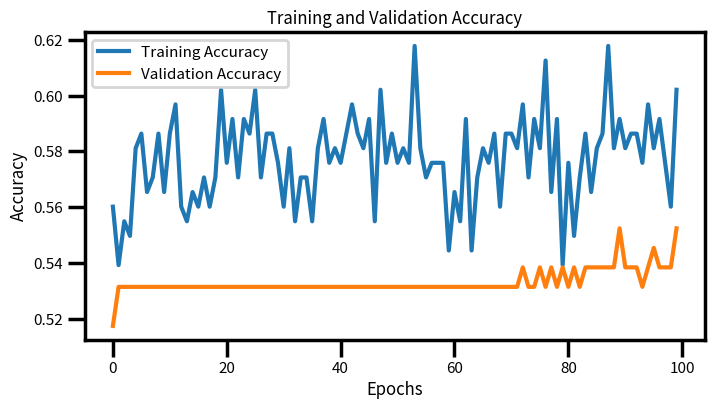

5/5 [==============================] - 1s 5ms/step
Accuracy: 0.5524475524475524


In [ ]:
is_rising_prediction_2330_tf = StockPriceModel(c_2330.get_data([1, 2]), config=config, mode='is_rising')
is_rising_prediction_2330_tf.run()

技術面+情感面

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 80)                34880     
                                                                 
 dropout_14 (Dropout)        (None, 80)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 81        
                                                                 
Total params: 34961 (136.57 KB)
Trainable params: 34961 (136.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


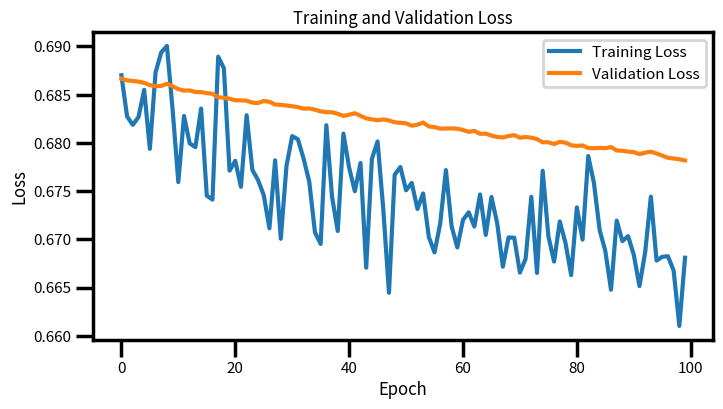

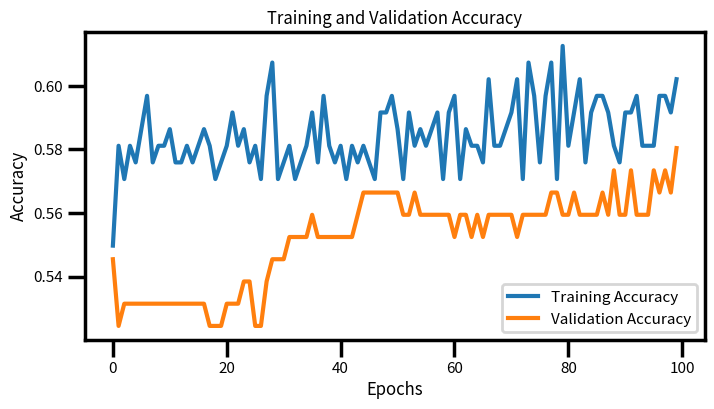

5/5 [==============================] - 1s 5ms/step
Accuracy: 0.5804195804195804


In [ ]:
is_rising_prediction_2330_ts = StockPriceModel(c_2330.get_data([1, 3]), config=config, mode='is_rising')
is_rising_prediction_2330_ts.run()

技術面+基本面+情感面

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 80)                45760     
                                                                 
 dropout_15 (Dropout)        (None, 80)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 81        
                                                                 
Total params: 45841 (179.07 KB)
Trainable params: 45841 (179.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


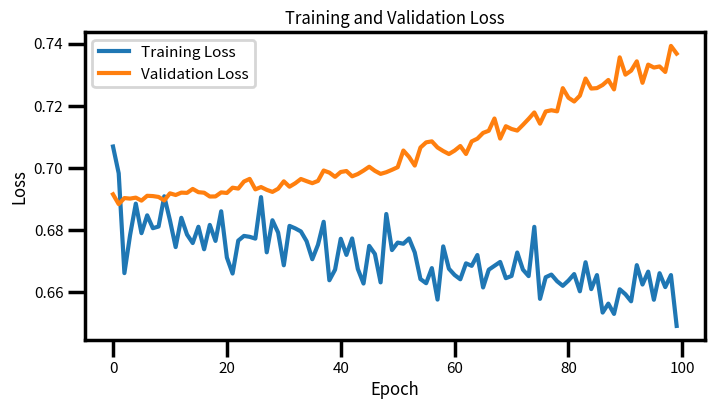

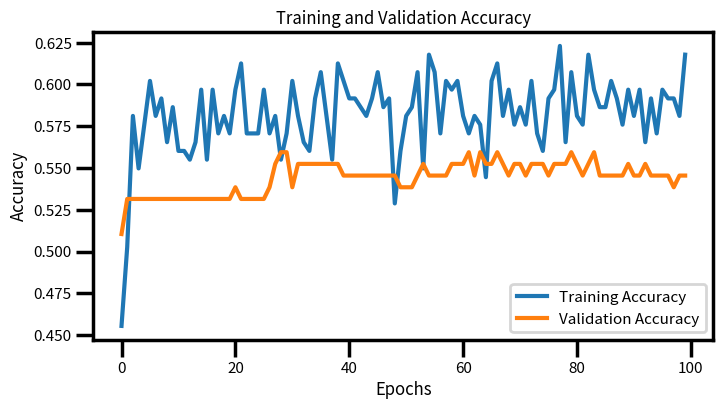

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.5454545454545454


In [ ]:
is_rising_prediction_2330 = StockPriceModel(c_2330.get_data(), config=config, mode='is_rising')
is_rising_prediction_2330.run()

### 2454聯發科

技術面

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 80)                32000     
                                                                 
 dropout_24 (Dropout)        (None, 80)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 81        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


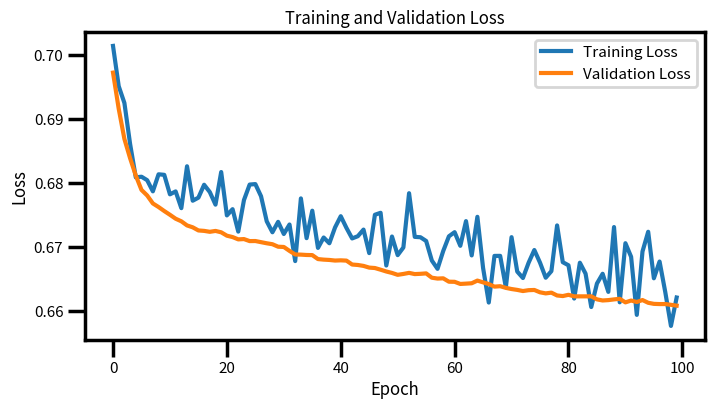

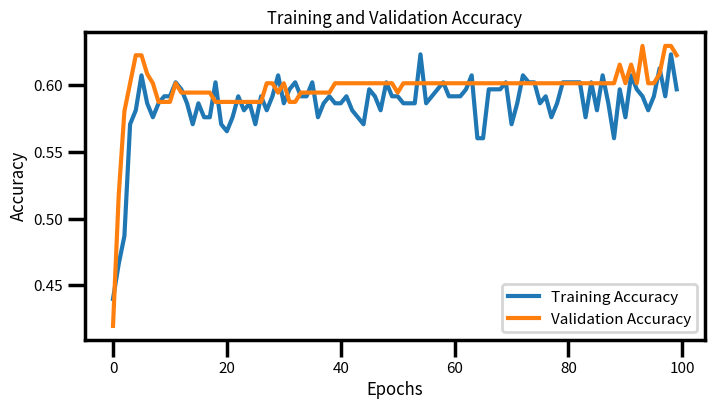

5/5 [==============================] - 1s 4ms/step
Accuracy: 0.6223776223776224


In [ ]:
is_rising_prediction_2454_t = StockPriceModel(c_2454.get_data(1), config=config, mode='is_rising')
is_rising_prediction_2454_t.run()

技術面+基本面

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 80)                42880     
                                                                 
 dropout_25 (Dropout)        (None, 80)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 81        
                                                                 
Total params: 42961 (167.82 KB)
Trainable params: 42961 (167.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


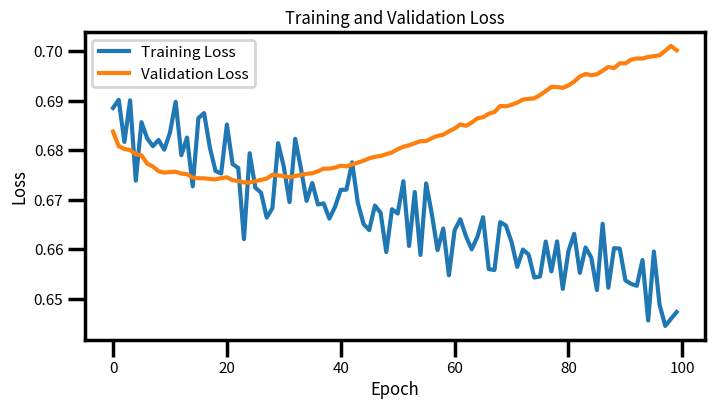

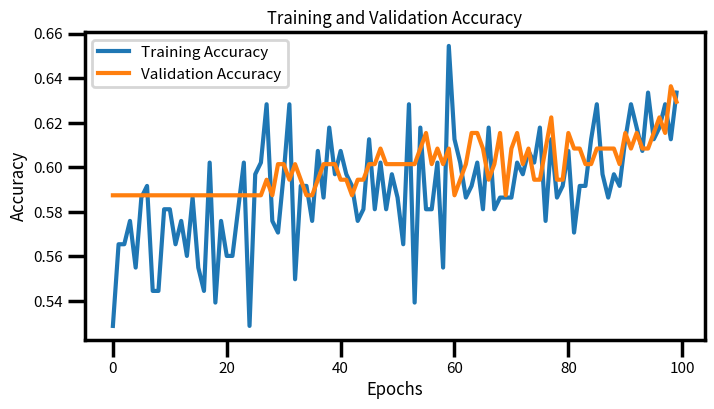

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.6293706293706294


In [ ]:
is_rising_prediction_2454_tf = StockPriceModel(c_2454.get_data([1, 2]), config=config, mode='is_rising')
is_rising_prediction_2454_tf.run()

技術面+情感面

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 80)                34880     
                                                                 
 dropout_26 (Dropout)        (None, 80)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 81        
                                                                 
Total params: 34961 (136.57 KB)
Trainable params: 34961 (136.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


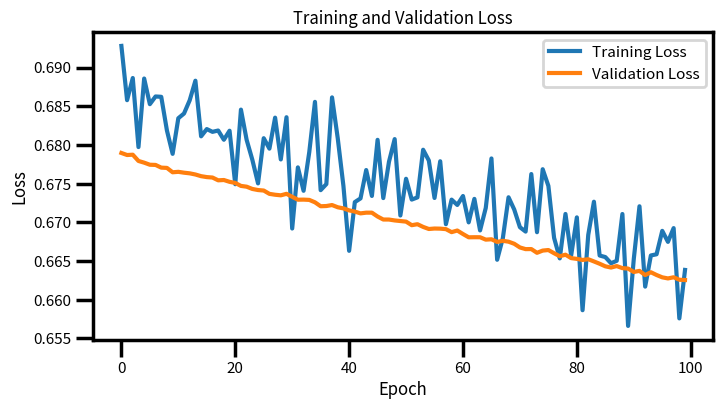

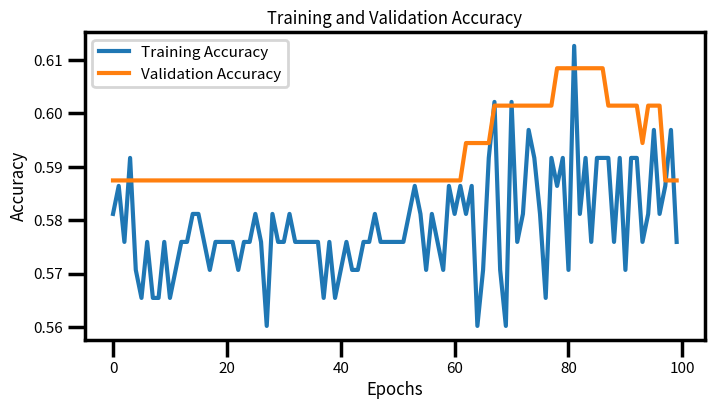

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.5874125874125874


In [ ]:
is_rising_prediction_2454_ts = StockPriceModel(c_2454.get_data([1, 3]), config=config, mode='is_rising')
is_rising_prediction_2454_ts.run()

技術面+基本面+情感面

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 80)                45760     
                                                                 
 dropout_27 (Dropout)        (None, 80)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 81        
                                                                 
Total params: 45841 (179.07 KB)
Trainable params: 45841 (179.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


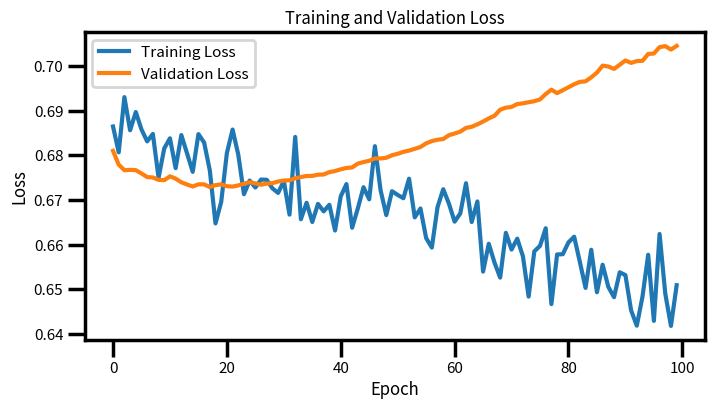

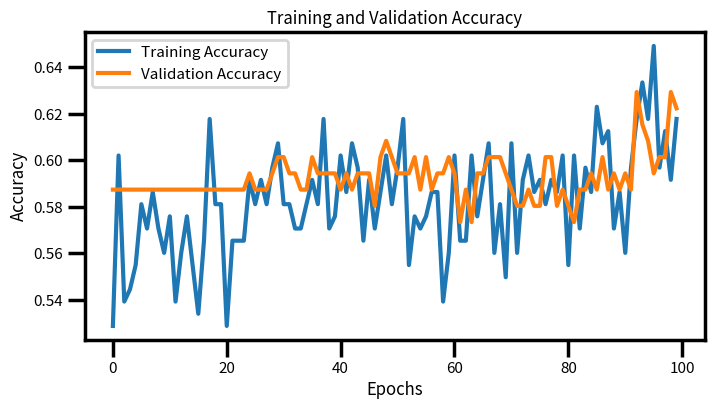

5/5 [==============================] - 0s 5ms/step
Accuracy: 0.6223776223776224


In [ ]:
is_rising_prediction_2454 = StockPriceModel(c_2454.get_data(), config=config, mode='is_rising')
is_rising_prediction_2454.run()